In [1]:
import datetime
import logging
import time

import numpy as np
import pandas as pd
import torch
from lightning import Trainer
from matplotlib import pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity

from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import Query
from dal_toolbox.active_learning.strategies.typiclust import kmeans
from dal_toolbox.active_learning.strategies.xpal import xpal_gain
from dal_toolbox.datasets.utils import FeatureDatasetWrapper
from dal_toolbox.metrics import Accuracy, BrierScore, ExpectedCalibrationError, AdaptiveCalibrationError
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.deterministic.linear import LinearModel
from dal_toolbox.models.parzen_window_classifier import PWCLightning
from dal_toolbox.utils import _calculate_mean_gamma, kernels, seed_everything

logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

In [2]:
class XPALClust(Query):
    MIN_CLUSTER_SIZE = 5
    MAX_NUM_CLUSTERS = 500
    K_NN = 20

    def __init__(self, num_classes, S, alpha_c, alpha_x, subset_size=None, random_seed=None):
        super().__init__(random_seed)

        self.num_classes = num_classes
        self.S = S
        self.alpha_c_ = alpha_c
        self.alpha_x_ = alpha_x
        self.subset_size = subset_size
        self.random_seed = random_seed

    def query(self, *, model, clust_al_datamodule, xpal_al_datamodule, xpalclustswitch_al_datamodule, acq_size, gamma, switch, **kwargs):
        """Compute score for each unlabeled sample. Score is to be maximized.
        Parameters
        ----------
        unlabeled_indices: array-like, shape (n_unlabeled_samples)
        Returns
        -------
        scores: array-like, shape (n_unlabeled_samples)
            Score of each unlabeled sample.
        """
        # compute frequency estimates for evaluation set (K_x) and candidate set (K_c)
        strategies = ["xpal", "xpalclust", "xpalclustswitch"]
        metrics = {"xpal": {}, "xpalclust": {}, "xpalclustswitch": {}}
        if "xpal" in strategies:
            seed_everything(self.random_seed)
            unlabeled_dataloader, unlabeled_indices = xpal_al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)
            labeled_loader, labeled_indices = xpal_al_datamodule.labeled_dataloader()



            if self.subset_size is None:
                S_ = self.S

                mapped_labeled_indices = labeled_indices
                mapped_unlabeled_indices = unlabeled_indices
            else:
                # Deletes entries from S, that are not part of the labeled/unlabeled subset
                existing_indices = np.concatenate([unlabeled_indices, labeled_indices])
                indices_to_remove = np.arange(self.S.shape[0])
                mask = np.equal.outer(indices_to_remove, existing_indices)
                indices_to_remove = indices_to_remove[~np.logical_or.reduce(mask, axis=1)]

                S_ = np.delete(self.S, indices_to_remove, 0)
                S_ = np.delete(S_, indices_to_remove, 1)

                # Remapping indices
                mapping = np.argsort(np.argsort(existing_indices))
                mapped_labeled_indices = mapping[len(unlabeled_indices):]
                mapped_unlabeled_indices = mapping[:len(unlabeled_indices)]

            y_labeled = []

            for batch in labeled_loader:
                y_labeled.append(batch[1])
            if len(y_labeled) > 0:
                y_labeled = torch.cat(y_labeled).tolist()

            Z = np.eye(self.num_classes)[y_labeled]
            K_x = S_[:, mapped_labeled_indices] @ Z
            K_c = K_x[mapped_unlabeled_indices]

            # calculate loss reduction for each unlabeled sample
            gains = xpal_gain(K_c=K_c, K_x=K_x, S=S_[mapped_unlabeled_indices], alpha_c=self.alpha_c_,
                              alpha_x=self.alpha_x_)

            top_gains, xpal_indices = torch.topk(torch.Tensor(gains), acq_size)
            xpal_actual_indices = [int(unlabeled_indices[i]) for i in xpal_indices]

            unlabeled_features = model.get_representations(unlabeled_dataloader)

            top_gains = np.array(top_gains)
            metrics["xpal"]["max_gain"] = top_gains.max()
            metrics["xpal"]["min_gain"] = top_gains.min()
            metrics["xpal"]["mean_gain"] = top_gains.mean()
            metrics["xpal"]["entropy_gain"] = -np.sum(top_gains * np.log2(top_gains))

            chosen_features = unlabeled_features[xpal_indices]

            feature_kernel = rbf_kernel(chosen_features, chosen_features, gamma=gamma)
            metrics["xpal"]["gram_determinant"] = np.linalg.det(feature_kernel)
            metrics["xpal"]["gram_log_determinant"] = np.log(np.linalg.det(feature_kernel))
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpal"]["max_rbf_similarity"] = np.nanmax(feature_kernel)
            metrics["xpal"]["min_rbf_similarity"] = np.nanmin(feature_kernel)
            metrics["xpal"]["mean_rbf_similarity"] = np.nanmean(feature_kernel) / 2.0

            feature_kernel = cosine_similarity(chosen_features, chosen_features)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpal"]["max_cosine_similarity"] = np.nanmax(feature_kernel)
            metrics["xpal"]["min_cosine_similarity"] = np.nanmin(feature_kernel)
            metrics["xpal"]["mean_cosine_similarity"] = np.nanmean(feature_kernel) / 2.0

            metrics["xpal"]["calinski_harabasz_score"] = np.nan
            metrics["xpal"]["davies_bouldin_score"] = np.nan

        if "xpalclust" in strategies:
            seed_everything(self.random_seed)
            unlabeled_dataloader, unlabeled_indices = clust_al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)
            labeled_loader, labeled_indices = clust_al_datamodule.labeled_dataloader()

            if self.subset_size is None:
                S_ = self.S

                mapped_labeled_indices = labeled_indices
                mapped_unlabeled_indices = unlabeled_indices
            else:
                # Deletes entries from S, that are not part of the labeled/unlabeled subset
                existing_indices = np.concatenate([unlabeled_indices, labeled_indices])
                indices_to_remove = np.arange(self.S.shape[0])
                mask = np.equal.outer(indices_to_remove, existing_indices)
                indices_to_remove = indices_to_remove[~np.logical_or.reduce(mask, axis=1)]

                S_ = np.delete(self.S, indices_to_remove, 0)
                S_ = np.delete(S_, indices_to_remove, 1)

                # Remapping indices
                mapping = np.argsort(np.argsort(existing_indices))
                mapped_labeled_indices = mapping[len(unlabeled_indices):]
                mapped_unlabeled_indices = mapping[:len(unlabeled_indices)]

            y_labeled = []

            for batch in labeled_loader:
                y_labeled.append(batch[1])
            if len(y_labeled) > 0:
                y_labeled = torch.cat(y_labeled).tolist()

            Z = np.eye(self.num_classes)[y_labeled]
            K_x = S_[:, mapped_labeled_indices] @ Z
            K_c = K_x[mapped_unlabeled_indices]

            # calculate loss reduction for each unlabeled sample
            gains = xpal_gain(K_c=K_c, K_x=K_x, S=S_[mapped_unlabeled_indices], alpha_c=self.alpha_c_,
                              alpha_x=self.alpha_x_)

            num_clusters = min(len(labeled_indices) + acq_size, self.MAX_NUM_CLUSTERS)

            unlabeled_features = model.get_representations(unlabeled_dataloader)
            if len(labeled_indices) > 0:
                labeled_features = model.get_representations(labeled_loader)
            else:
                labeled_features = torch.Tensor([])

            features = torch.cat((labeled_features, unlabeled_features))
            clusters = kmeans(features, num_clusters=num_clusters)

            metrics["xpalclust"]["calinski_harabasz_score"] = calinski_harabasz_score(features, clusters)
            metrics["xpalclust"]["davies_bouldin_score"] = davies_bouldin_score(features, clusters)

            labels = clusters.copy()
            existing_indices = np.arange(len(labeled_indices))

            # counting cluster sizes and number of labeled samples per cluster
            cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
            cluster_labeled_counts = np.bincount(labels[existing_indices], minlength=len(cluster_ids))
            clusters_df = pd.DataFrame(
                {'cluster_id': cluster_ids, 'cluster_size': cluster_sizes, 'existing_count': cluster_labeled_counts,
                 'neg_cluster_size': -1 * cluster_sizes})
            # drop too small clusters
            clusters_df = clusters_df[clusters_df.cluster_size > self.MIN_CLUSTER_SIZE]
            # sort clusters by lowest number of existing samples, and then by cluster sizes (large to small)
            clusters_df = clusters_df.sort_values(['existing_count', 'neg_cluster_size'])
            labels[existing_indices] = -1

            selected = []
            top_gains = []

            for i in range(acq_size):
                cluster = clusters_df.iloc[i % len(clusters_df)].cluster_id
                indices = (labels == cluster).nonzero()[0] - len(labeled_indices)
                rel_gains = gains[indices]
                idx = indices[rel_gains.argmax()]
                selected.append(idx)
                top_gains.append(rel_gains.max())
                labels[idx] = -1

            selected = np.array(selected)
            xpalclust_actual_indices = [unlabeled_indices[i] for i in selected]

            top_gains = np.array(top_gains)
            metrics["xpalclust"]["max_gain"] = top_gains.max()
            metrics["xpalclust"]["min_gain"] = top_gains.min()
            metrics["xpalclust"]["mean_gain"] = top_gains.mean()
            metrics["xpalclust"]["entropy_gain"] = -np.sum(top_gains * np.log2(top_gains))

            chosen_features = unlabeled_features[selected]

            feature_kernel = rbf_kernel(chosen_features, chosen_features, gamma=gamma)
            metrics["xpalclust"]["gram_determinant"] = np.linalg.det(feature_kernel)
            metrics["xpalclust"]["gram_log_determinant"] = np.log(np.linalg.det(feature_kernel))
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclust"]["max_rbf_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclust"]["min_rbf_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclust"]["mean_rbf_similarity"] = np.nanmean(feature_kernel)

            feature_kernel = cosine_similarity(chosen_features, chosen_features)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclust"]["max_cosine_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclust"]["min_cosine_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclust"]["mean_cosine_similarity"] = np.nanmean(feature_kernel)

        if "xpalclustswitch" in strategies:
            seed_everything(self.random_seed)
            unlabeled_dataloader, unlabeled_indices = xpalclustswitch_al_datamodule.unlabeled_dataloader(subset_size=self.subset_size)
            labeled_loader, labeled_indices = xpalclustswitch_al_datamodule.labeled_dataloader()

            if self.subset_size is None:
                S_ = self.S

                mapped_labeled_indices = labeled_indices
                mapped_unlabeled_indices = unlabeled_indices
            else:
                # Deletes entries from S, that are not part of the labeled/unlabeled subset
                existing_indices = np.concatenate([unlabeled_indices, labeled_indices])
                indices_to_remove = np.arange(self.S.shape[0])
                mask = np.equal.outer(indices_to_remove, existing_indices)
                indices_to_remove = indices_to_remove[~np.logical_or.reduce(mask, axis=1)]

                S_ = np.delete(self.S, indices_to_remove, 0)
                S_ = np.delete(S_, indices_to_remove, 1)

                # Remapping indices
                mapping = np.argsort(np.argsort(existing_indices))
                mapped_labeled_indices = mapping[len(unlabeled_indices):]
                mapped_unlabeled_indices = mapping[:len(unlabeled_indices)]

            y_labeled = []

            for batch in labeled_loader:
                y_labeled.append(batch[1])
            if len(y_labeled) > 0:
                y_labeled = torch.cat(y_labeled).tolist()

            Z = np.eye(self.num_classes)[y_labeled]
            K_x = S_[:, mapped_labeled_indices] @ Z
            K_c = K_x[mapped_unlabeled_indices]

            # calculate loss reduction for each unlabeled sample
            gains = xpal_gain(K_c=K_c, K_x=K_x, S=S_[mapped_unlabeled_indices], alpha_c=self.alpha_c_,
                              alpha_x=self.alpha_x_)

            if switch:
                top_gains, xpalclustswitch_indices = torch.topk(torch.Tensor(gains), acq_size)
                xpalclustswitch_actual_indices = [int(unlabeled_indices[i]) for i in xpalclustswitch_indices]

                unlabeled_features = model.get_representations(unlabeled_dataloader)
                chosen_features = unlabeled_features[xpalclustswitch_indices]

                metrics["xpalclustswitch"]["calinski_harabasz_score"] = np.nan
                metrics["xpalclustswitch"]["davies_bouldin_score"] = np.nan
            else:
                num_clusters = min(len(labeled_indices) + acq_size, self.MAX_NUM_CLUSTERS)

                unlabeled_features = model.get_representations(unlabeled_dataloader)
                if len(labeled_indices) > 0:
                    labeled_features = model.get_representations(labeled_loader)
                else:
                    labeled_features = torch.Tensor([])

                features = torch.cat((labeled_features, unlabeled_features))
                clusters = kmeans(features, num_clusters=num_clusters)

                metrics["xpalclustswitch"]["calinski_harabasz_score"] = calinski_harabasz_score(features, clusters)
                metrics["xpalclustswitch"]["davies_bouldin_score"] = davies_bouldin_score(features, clusters)

                labels = clusters.copy()
                existing_indices = np.arange(len(labeled_indices))

                # counting cluster sizes and number of labeled samples per cluster
                cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
                cluster_labeled_counts = np.bincount(labels[existing_indices], minlength=len(cluster_ids))
                clusters_df = pd.DataFrame(
                    {'cluster_id': cluster_ids, 'cluster_size': cluster_sizes, 'existing_count': cluster_labeled_counts,
                     'neg_cluster_size': -1 * cluster_sizes})
                # drop too small clusters
                clusters_df = clusters_df[clusters_df.cluster_size > self.MIN_CLUSTER_SIZE]
                # sort clusters by lowest number of existing samples, and then by cluster sizes (large to small)
                clusters_df = clusters_df.sort_values(['existing_count', 'neg_cluster_size'])
                labels[existing_indices] = -1

                selected = []
                top_gains = []

                for i in range(acq_size):
                    cluster = clusters_df.iloc[i % len(clusters_df)].cluster_id
                    indices = (labels == cluster).nonzero()[0] - len(labeled_indices)
                    rel_gains = gains[indices]
                    idx = indices[rel_gains.argmax()]
                    selected.append(idx)
                    top_gains.append(rel_gains.max())
                    labels[idx] = -1

                selected = np.array(selected)
                xpalclustswitch_actual_indices = [unlabeled_indices[i] for i in selected]

                chosen_features = unlabeled_features[selected]

            top_gains = np.array(top_gains)
            metrics["xpalclustswitch"]["max_gain"] = top_gains.max()
            metrics["xpalclustswitch"]["min_gain"] = top_gains.min()
            metrics["xpalclustswitch"]["mean_gain"] = top_gains.mean()
            metrics["xpalclustswitch"]["entropy_gain"] = -np.sum(top_gains * np.log2(top_gains))

            feature_kernel = rbf_kernel(chosen_features, chosen_features, gamma=gamma)
            metrics["xpalclustswitch"]["gram_determinant"] = np.linalg.det(feature_kernel)
            metrics["xpalclustswitch"]["gram_log_determinant"] = np.log(np.linalg.det(feature_kernel))
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclustswitch"]["max_rbf_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclustswitch"]["min_rbf_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclustswitch"]["mean_rbf_similarity"] = np.nanmean(feature_kernel)

            feature_kernel = cosine_similarity(chosen_features, chosen_features)
            np.fill_diagonal(feature_kernel, np.nan)  # Don't need self similarity for max/min/mean
            metrics["xpalclustswitch"]["max_cosine_similarity"] = np.nanmax(feature_kernel)
            metrics["xpalclustswitch"]["min_cosine_similarity"] = np.nanmin(feature_kernel)
            metrics["xpalclustswitch"]["mean_cosine_similarity"] = np.nanmean(feature_kernel)

        return xpalclust_actual_indices, xpal_actual_indices, xpalclustswitch_actual_indices, metrics

In [3]:
def do_metric_al(switch,
                 random_seed=0,
                 data_path="../simclr_resnet18_cifar10.pth",
                 model_name="parzen_window",
                 train_batch_size=1000,
                 predict_batch_size=1000,
                 num_epochs=2,
                 learning_rate=0.2,  # Only relevant for linear
                 weight_decay=0.0,  # Only relevant for linear
                 al_n_init=10,
                 al_acq_size=10,
                 al_n_cycle=9,
                 al_init_strategy="XPALCLust",
                 alpha=1e-11,
                 subset_size=10000):
    seed_everything(random_seed)
    results = {}
    queried_indices = {}
    metrics = {}
    cycle_metrics = None

    data = FeatureDatasetWrapper(data_path)

    feature_size = data.num_features
    trainset = data.train_dataset
    train_features = torch.stack([batch[0] for batch in trainset])
    queryset = data.query_dataset
    valset = data.val_dataset
    testset = data.test_dataset

    num_classes = data.num_classes

    gamma = _calculate_mean_gamma(train_features)
    print(f"Calculated gamma as {gamma}.")

    # Setup Query
    print('Building query strategy: XPALClust')
    S = kernels(X=train_features, Y=train_features, metric="rbf", gamma=gamma)
    al_strategy = XPALClust(num_classes, S, subset_size=subset_size, alpha_c=alpha, alpha_x=alpha, random_seed=random_seed)

    # Setup Model
    print(f"Building model: {model_name}")

    if model_name == "parzen_window":
        accelerator = "cpu"
        xpalclust_model = PWCLightning(n_classes=num_classes,
                                       random_state=random_seed,
                                       kernel_params={"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None},
                                       train_metrics={'train_acc': Accuracy()},
                                       val_metrics={'val_acc': Accuracy()})

        xpal_model = PWCLightning(n_classes=num_classes,
                                  random_state=random_seed,
                                  kernel_params={"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None},
                                  train_metrics={'train_acc': Accuracy()},
                                  val_metrics={'val_acc': Accuracy()})

        xpalclustswitch_model = PWCLightning(n_classes=num_classes,
                          random_state=random_seed,
                          kernel_params={"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None},
                          train_metrics={'train_acc': Accuracy()},
                          val_metrics={'val_acc': Accuracy()})
    elif model_name == "linear":
        accelerator = "auto"
        xpalclust_model = LinearModel(feature_size, num_classes)
        optimizer = torch.optim.SGD(xpalclust_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        xpalclust_model = DeterministicModel(
            xpalclust_model, optimizer=optimizer, lr_scheduler=lr_scheduler,
            train_metrics={'train_acc': Accuracy()},
            val_metrics={'val_acc': Accuracy()},
        )

        xpal_model = LinearModel(feature_size, num_classes)
        optimizer = torch.optim.SGD(xpal_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        xpal_model = DeterministicModel(
            xpal_model, optimizer=optimizer, lr_scheduler=lr_scheduler,
            train_metrics={'train_acc': Accuracy()},
            val_metrics={'val_acc': Accuracy()},
        )

        xpalclustswitch_model = LinearModel(feature_size, num_classes)
        optimizer = torch.optim.SGD(xpalclustswitch_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        xpalclustswitch_model = DeterministicModel(
            xpalclustswitch_model, optimizer=optimizer, lr_scheduler=lr_scheduler,
            train_metrics={'train_acc': Accuracy()},
            val_metrics={'val_acc': Accuracy()},
        )
    else:
        raise NotImplementedError()

    # Setup AL Module
    start = time.time()
    print(f'Creating AL Datamodule with {al_n_init} initial samples, '
          f'chosen with strategy {al_init_strategy}. ', end="")
    xpal_al_datamodule = ActiveLearningDataModule(
        train_dataset=trainset,
        query_dataset=queryset,
        val_dataset=valset,
        test_dataset=testset,
        train_batch_size=train_batch_size,
        predict_batch_size=predict_batch_size,
    )
    xpalclust_al_datamodule = ActiveLearningDataModule(
        train_dataset=trainset,
        query_dataset=queryset,
        val_dataset=valset,
        test_dataset=testset,
        train_batch_size=train_batch_size,
        predict_batch_size=predict_batch_size,
    )
    xpalclustswitch_al_datamodule = ActiveLearningDataModule(
        train_dataset=trainset,
        query_dataset=queryset,
        val_dataset=valset,
        test_dataset=testset,
        train_batch_size=train_batch_size,
        predict_batch_size=predict_batch_size,
    )

    if al_init_strategy == "random":
        xpal_al_datamodule.random_init(n_samples=al_n_init)
        xpalclust_al_datamodule.random_init(n_samples=al_n_init)
        xpalclustswitch_al_datamodule.random_init(n_samples=al_n_init)
    else:  # Otherwise we sample with XPALClust
        xpalclust_indices, xpal_indices, xpalclustswitch_indices, cycle_metrics = al_strategy.query(
            switch=False,
            model=xpalclust_model,
            clust_al_datamodule=xpalclust_al_datamodule,
            xpal_al_datamodule=xpal_al_datamodule,
            xpalclustswitch_al_datamodule=xpalclustswitch_al_datamodule,
            acq_size=al_acq_size,
            gamma=gamma
        )
        xpalclust_al_datamodule.update_annotations(xpalclust_indices)
        xpal_al_datamodule.update_annotations(xpal_indices)
        xpalclustswitch_al_datamodule.update_annotations(xpalclustswitch_indices)
    queried_indices['cycle0'] = {}
    queried_indices['cycle0']["xpalclust"] = xpalclust_al_datamodule.labeled_indices
    queried_indices['cycle0']["xpal"] = xpal_al_datamodule.labeled_indices
    queried_indices['cycle0']["xpalclustswitch"] = xpalclustswitch_al_datamodule.labeled_indices
    metrics['cycle0'] = cycle_metrics
    print(f"Took {time.time() - start} seconds.")
    print(xpalclust_al_datamodule.labeled_indices)
    print(xpalclustswitch_al_datamodule.labeled_indices)

    # Active Learning Cycles
    for i_acq in range(0, al_n_cycle + 1):
        print(f'Starting AL iteration {i_acq} / {al_n_cycle}')
        xpalclust_cycle_results = {}
        xpal_cycle_results = {}
        xpalclustswitch_cycle_results = {}

        if i_acq != 0:
            start = time.time()
            print(f'Querying {al_acq_size} samples with strategy XPALClust. ', end="")
            xpalclust_indices, xpal_indices, xpalclustswitch_indices, cycle_metrics = al_strategy.query(
                switch=(i_acq * al_acq_size + al_n_init) >= switch,
                model=xpalclust_model,
                xpal_al_datamodule=xpal_al_datamodule,
                clust_al_datamodule=xpalclust_al_datamodule,
                xpalclustswitch_al_datamodule=xpalclustswitch_al_datamodule,
                acq_size=al_acq_size,
                gamma=gamma
            )
            print(f"Indices XPAL: f{xpal_indices}")
            print(f"Indices XPALClust: f{xpalclust_indices}")
            print(f"Indices XPALClustSwitch: f{xpalclustswitch_indices}")
            xpalclust_al_datamodule.update_annotations(xpalclust_indices)
            xpal_al_datamodule.update_annotations(xpal_indices)
            xpalclustswitch_al_datamodule.update_annotations(xpalclustswitch_indices)
            queried_indices[f'cycle{i_acq}'] = {}
            queried_indices[f'cycle{i_acq}']["xpalclust"] = xpalclust_al_datamodule.labeled_indices
            queried_indices[f'cycle{i_acq}']["xpal"] = xpal_al_datamodule.labeled_indices
            queried_indices[f'cycle{i_acq}']["xpalclustswitch"] = xpalclustswitch_al_datamodule.labeled_indices
            metrics[f'cycle{i_acq}'] = cycle_metrics
            print(f"Took {time.time() - start} seconds.")

        #  model cold start
        xpalclust_model.reset_states()
        xpal_model.reset_states()
        xpalclustswitch_model.reset_states()

        # Train with updated annotations
        callbacks = []
        trainer = Trainer(
            max_epochs=num_epochs,
            enable_checkpointing=False,
            callbacks=callbacks,
            accelerator=accelerator,
            default_root_dir="XPALCLustMetrics/",
            enable_progress_bar=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(xpalclust_model, xpalclust_al_datamodule)
        predictions = trainer.predict(xpalclust_model, xpalclust_al_datamodule.test_dataloader())
        logits = torch.cat([pred[0] for pred in predictions])
        targets = torch.cat([pred[1] for pred in predictions])

        test_stats = {
            'accuracy': Accuracy()(logits, targets).item(),
            'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
            'brier': BrierScore()(logits, targets).item(),
            'ece': ExpectedCalibrationError()(logits, targets).item(),
            'ace': AdaptiveCalibrationError()(logits, targets).item(),
        }
        print(f'Evaluation stats XPALClust: {test_stats}', )

        xpalclust_cycle_results.update({
            "test_stats": test_stats,
            "labeled_indices": xpalclust_al_datamodule.labeled_indices,
            "n_labeled_samples": len(xpalclust_al_datamodule.labeled_indices),
            "unlabeled_indices": xpalclust_al_datamodule.unlabeled_indices,
            "n_unlabeled_samples": len(xpalclust_al_datamodule.unlabeled_indices),
        })
        results[f'cycle{i_acq}'] = {}
        results[f'cycle{i_acq}']["xpalclust"] = xpalclust_cycle_results
        
        trainer = Trainer(
            max_epochs=num_epochs,
            enable_checkpointing=False,
            callbacks=callbacks,
            accelerator=accelerator,
            default_root_dir="XPALCLustMetrics/",
            enable_progress_bar=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(xpal_model, xpal_al_datamodule)
        predictions = trainer.predict(xpal_model, xpal_al_datamodule.test_dataloader())
        logits = torch.cat([pred[0] for pred in predictions])
        targets = torch.cat([pred[1] for pred in predictions])

        test_stats = {
            'accuracy': Accuracy()(logits, targets).item(),
            'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
            'brier': BrierScore()(logits, targets).item(),
            'ece': ExpectedCalibrationError()(logits, targets).item(),
            'ace': AdaptiveCalibrationError()(logits, targets).item(),
        }
        print(f'Evaluation stats XPAL: {test_stats}', )

        xpal_cycle_results.update({
            "test_stats": test_stats,
            "labeled_indices": xpal_al_datamodule.labeled_indices,
            "n_labeled_samples": len(xpal_al_datamodule.labeled_indices),
            "unlabeled_indices": xpal_al_datamodule.unlabeled_indices,
            "n_unlabeled_samples": len(xpal_al_datamodule.unlabeled_indices),
        })
        results[f'cycle{i_acq}']["xpal"] = xpal_cycle_results


        trainer = Trainer(
            max_epochs=num_epochs,
            enable_checkpointing=False,
            callbacks=callbacks,
            accelerator=accelerator,
            default_root_dir="XPALCLustMetrics/",
            enable_progress_bar=False,
            check_val_every_n_epoch=1,
        )
        trainer.fit(xpalclustswitch_model, xpalclustswitch_al_datamodule)
        predictions = trainer.predict(xpalclustswitch_model, xpalclustswitch_al_datamodule.test_dataloader())
        logits = torch.cat([pred[0] for pred in predictions])
        targets = torch.cat([pred[1] for pred in predictions])

        test_stats = {
            'accuracy': Accuracy()(logits, targets).item(),
            'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
            'brier': BrierScore()(logits, targets).item(),
            'ece': ExpectedCalibrationError()(logits, targets).item(),
            'ace': AdaptiveCalibrationError()(logits, targets).item(),
        }
        print(f'Evaluation stats XPALClustSwitch: {test_stats}', )

        xpalclustswitch_cycle_results.update({
            "test_stats": test_stats,
            "labeled_indices": xpalclustswitch_al_datamodule.labeled_indices,
            "n_labeled_samples": len(xpalclustswitch_al_datamodule.labeled_indices),
            "unlabeled_indices": xpalclustswitch_al_datamodule.unlabeled_indices,
            "n_unlabeled_samples": len(xpalclustswitch_al_datamodule.unlabeled_indices),
        })
        results[f'cycle{i_acq}']["xpalclustswitch"] = xpalclustswitch_cycle_results

    return results, queried_indices, metrics

def plot_strategy_metrics(result_list, metric_list, title="", loc="best"):
    fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)
    fig.tight_layout()
    fig.supxlabel('Number of Annotations')

    for strat, line in zip(["xpalclust", "xpal", "xpalclustswitch"], ["-", "--", ":"]):
        num_samples_list = []
        accuracies_list = []

        calinski_harabasz_scores_list = []
        davies_bouldin_scores_list = []
        max_gains_list = []
        min_gains_list = []
        mean_gains_list = []
        entropy_gains_list = []
        gram_determinants_list = []
        log_gram_determinants_list = []
        max_rbf_similarities_list = []
        min_rbf_similarities_list = []
        mean_rbf_similarities_list = []
        max_cosine_similarities_list = []
        min_cosine_similarities_list = []
        mean_cosine_similarities_list = []

        for results, metrics in zip(result_list, metric_list):
            num_samples = []
            accuracies = []

            calinski_harabasz_scores = []
            davies_bouldin_scores = []
            max_gains = []
            min_gains = []
            mean_gains = []
            entropy_gains = []
            gram_determinants = []
            log_gram_determinants = []
            max_rbf_similarities = []
            min_rbf_similarities = []
            mean_rbf_similarities = []
            max_cosine_similarities = []
            min_cosine_similarities = []
            mean_cosine_similarities = []

            for cycle, m in results.items():
                num_samples.append(m[strat]['n_labeled_samples'])
                accuracies.append(m[strat]['test_stats']['accuracy'])

            for cycle, m in metrics.items():
                calinski_harabasz_scores.append(m[strat]['calinski_harabasz_score'])
                davies_bouldin_scores.append(m[strat]['davies_bouldin_score'])
                max_gains.append(m[strat]['max_gain'])
                min_gains.append(m[strat]['min_gain'])
                mean_gains.append(m[strat]['mean_gain'])
                entropy_gains.append(m[strat]['entropy_gain'])
                gram_determinants.append(m[strat]['gram_determinant'])
                log_gram_determinants.append(m[strat]['gram_log_determinant'])
                max_rbf_similarities.append(m[strat]['max_rbf_similarity'])
                min_rbf_similarities.append(m[strat]['min_rbf_similarity'])
                mean_rbf_similarities.append(m[strat]['mean_rbf_similarity'])
                max_cosine_similarities.append(m[strat]['max_cosine_similarity'])
                min_cosine_similarities.append(m[strat]['min_cosine_similarity'])
                mean_cosine_similarities.append(m[strat]['mean_cosine_similarity'])

            num_samples_list.append(num_samples)
            accuracies_list.append(accuracies)

            calinski_harabasz_scores_list.append(calinski_harabasz_scores)
            davies_bouldin_scores_list.append(davies_bouldin_scores)
            max_gains_list.append(max_gains)
            min_gains_list.append(min_gains)
            mean_gains_list.append(mean_gains)
            entropy_gains_list.append(entropy_gains)
            gram_determinants_list.append(gram_determinants)
            log_gram_determinants_list.append(log_gram_determinants)
            max_rbf_similarities_list.append(max_rbf_similarities)
            min_rbf_similarities_list.append(min_rbf_similarities)
            mean_rbf_similarities_list.append(mean_rbf_similarities)
            max_cosine_similarities_list.append(max_cosine_similarities)
            min_cosine_similarities_list.append(min_cosine_similarities)
            mean_cosine_similarities_list.append(mean_cosine_similarities)

        num_samples = np.mean(num_samples_list, axis=0)
        accuracies = np.mean(accuracies_list, axis=0)
        accuracies_std = np.std(accuracies_list, axis=0)

        calinski_harabasz_scores = np.nanmean(calinski_harabasz_scores_list, axis=0)
        davies_bouldin_scores = np.nanmean(davies_bouldin_scores_list, axis=0)
        max_gains = np.mean(max_gains_list, axis=0)
        min_gains = np.mean(min_gains_list, axis=0)
        mean_gains = np.mean(mean_gains_list, axis=0)
        entropy_gains = np.mean(entropy_gains_list, axis=0)
        gram_determinants = np.nanmean(gram_determinants_list, axis=0)
        log_gram_determinants = np.nanmean(log_gram_determinants_list, axis=0)
        max_rbf_similarities = np.mean(max_rbf_similarities_list, axis=0)
        min_rbf_similarities = np.mean(min_rbf_similarities_list, axis=0)
        mean_rbf_similarities = np.mean(mean_rbf_similarities_list, axis=0)
        max_cosine_similarities = np.mean(max_cosine_similarities_list, axis=0)
        min_cosine_similarities = np.mean(min_cosine_similarities_list, axis=0)
        mean_cosine_similarities = np.mean(mean_cosine_similarities_list, axis=0)

        # Test Accuracy
        axes[0, 0].plot(num_samples, accuracies, color="orange", ls=line, label=strat)
        axes[0, 0].set_title("Test Accuracy")
        axes[0, 0].set_ylabel('Accuracy')

        # Clustermetrics
        if strat != "xpal":
            a = axes[0, 1].plot(num_samples, calinski_harabasz_scores, color="blue", ls=line, label="Calinski-Harabasz Score")
            secax = axes[0, 1].twinx()
            secax.spines['right'].set_color('red')
            secax.tick_params(axis='y', colors='red')
            secax.yaxis.label.set_color('red')
            b = secax.plot(num_samples, davies_bouldin_scores, ls=line, label="Davies-Bouldin Score", color="red")
            axes[0, 1].set_title("Clustermetrics")
            axes[0, 1].set_ylabel('Metric Score')
            lns = a + b
            labels = [l.get_label() for l in lns]
            axes[0, 1].legend(lns, labels)

        # Gains
        axes[0, 2].plot(num_samples, max_gains, color="red", ls=line, label="Max")
        axes[0, 2].plot(num_samples, min_gains, color="blue", ls=line, label="Min")
        axes[0, 2].plot(num_samples, mean_gains, color="green", ls=line, label="Mean")
        axes[0, 2].plot(num_samples, entropy_gains, color="cyan", ls=line, label="Entropy")
        axes[0, 2].set_title("Gains (log scaled)")
        axes[0, 2].set_ylabel('Gain')
        axes[0, 2].set_yscale('log')


        # Gram
        axes[1, 0].plot(num_samples, gram_determinants, color="blue", ls=line, label="Determinant")
        axes[1, 0].plot(num_samples, log_gram_determinants, color="red", ls=line, label="Log Determinant")
        axes[1, 0].set_title("Gram Matrix")
        axes[1, 0].set_ylabel('Value')

        # RBF
        axes[1, 1].plot(num_samples, max_rbf_similarities, color="red", ls=line, label="Max")
        axes[1, 1].plot(num_samples, min_rbf_similarities, color="green", ls=line, label="Min")
        axes[1, 1].plot(num_samples, mean_rbf_similarities, color="blue", ls=line, label="Mean")
        axes[1, 1].set_title("RBF Similarities (log-scaled)")
        axes[1, 1].set_ylabel('Similarity')
        axes[1, 1].set_yscale('log')


        # Cosine
        axes[1, 2].plot(num_samples, max_cosine_similarities, color="red", ls=line, label="Max")
        axes[1, 2].plot(num_samples, min_cosine_similarities, color="green", ls=line, label="Min")
        axes[1, 2].plot(num_samples, mean_cosine_similarities, color="blue", ls=line, label="Mean")
        axes[1, 2].set_title("Cosine Similarities")
        axes[1, 2].set_ylabel('Similarity')


        if strat == "xpalclust":
            axes[0, 2].legend()
            axes[1, 0].legend()
            axes[1, 1].legend()
            axes[1, 2].legend()

    axes[0, 0].legend()
    plt.show()

In [4]:
start = time.time()

result_list = []
indices_list = []
strategy_metric_list = []

for seed in range(0, 5):
    res, qi, strategy_metrics = do_metric_al(al_n_cycle=29, random_seed=seed, switch=125)
    result_list.append(res)
    indices_list.append(qi)
    strategy_metric_list.append(strategy_metrics)

print(f"Took {str(datetime.timedelta(seconds=int(time.time() - start)))} to execute.")

Global seed set to 0


Calculated gamma as 0.023506234674730845.
Building query strategy: XPALClust


Global seed set to 0


Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. 

Global seed set to 0
Global seed set to 0


Took 359.65978741645813 seconds.
[7683, 41252, 36037, 14474, 11981, 29104, 820, 29624, 12926, 33727]
[7683, 41252, 36037, 14474, 11981, 29104, 820, 29624, 12926, 33727]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.41749998927116394, 'nll': 2.061192274093628, 'brier': 0.8334531188011169, 'ece': 0.2520500421524048, 'ace': 0.10057417303323746}
Evaluation stats XPAL: {'accuracy': 0.2953999936580658, 'nll': 2.2005765438079834, 'brier': 0.8741779327392578, 'ece': 0.15866222977638245, 'ace': 0.06877116113901138}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.41749998927116394, 'nll': 2.061192274093628, 'brier': 0.8334531188011169, 'ece': 0.2520500421524048, 'ace': 0.10057417303323746}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[3137, 28187, 28016, 33814, 39231, 16968, 25877, 24612, 31644, 216]
Indices XPALClust: f[22894, 10395, 39231, 7361, 2617, 44923, 11909, 23243, 9687, 22954]
Indices XPALClustSwitch: f[22894, 10395, 39231, 7361, 2617, 44923, 11909, 23243, 9687, 22954]
Took 74.1342613697052 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5328999757766724, 'nll': 1.9939707517623901, 'brier': 0.8173351287841797, 'ece': 0.3637638986110687, 'ace': 0.10971734672784805}
Evaluation stats XPAL: {'accuracy': 0.3614000082015991, 'nll': 2.152928352355957, 'brier': 0.8620568513870239, 'ece': 0.2256966531276703, 'ace': 0.0910758227109909}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.5328999757766724, 'nll': 1.9939707517623901, 'brier': 0.8173351287841797, 'ece': 0.3637638986110687, 'ace': 0.10971734672784805}
Starting AL iteration 2 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[31662, 40793, 4121, 23042, 41967, 16585, 37529, 6931, 8169, 24730]
Indices XPALClust: f[31736, 322, 37328, 166, 22781, 3974, 6660, 31820, 11244, 38727]
Indices XPALClustSwitch: f[31736, 322, 37328, 166, 22781, 3974, 6660, 31820, 11244, 38727]
Took 50.741764307022095 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5934000015258789, 'nll': 1.9510583877563477, 'brier': 0.8064765930175781, 'ece': 0.4253508448600769, 'ace': 0.12086601555347443}
Evaluation stats XPAL: {'accuracy': 0.46799999475479126, 'nll': 2.0741653442382812, 'brier': 0.8409625291824341, 'ece': 0.3247625231742859, 'ace': 0.10789185017347336}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.5920000076293945, 'nll': 1.9517004489898682, 'brier': 0.8066504001617432, 'ece': 0.42384982109069824, 'ace': 0.12082574516534805}
Starting AL iteration 3 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[34012, 44482, 12135, 25532, 25536, 7153, 13211, 1523, 24060, 7058]
Indices XPALClust: f[38583, 44431, 25491, 32152, 29520, 39030, 30655, 22202, 5668, 13731]
Indices XPALClustSwitch: f[38583, 44431, 25491, 32152, 29520, 39030, 30655, 22202, 5668, 13731]
Took 47.35012483596802 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6118999719619751, 'nll': 1.9397406578063965, 'brier': 0.8033031821250916, 'ece': 0.4462154507637024, 'ace': 0.12243290990591049}
Evaluation stats XPAL: {'accuracy': 0.5515000224113464, 'nll': 2.019702911376953, 'brier': 0.8263906240463257, 'ece': 0.4025996923446655, 'ace': 0.11700055748224258}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6118999719619751, 'nll': 1.9397406578063965, 'brier': 0.8033031821250916, 'ece': 0.4462154507637024, 'ace': 0.12243290990591049}
Starting AL iteration 4 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[29884, 16166, 40710, 7361, 23406, 24645, 1568, 23052, 38570, 23487]
Indices XPALClust: f[5192, 28227, 4341, 18144, 39174, 34832, 7808, 13402, 42735, 44888]
Indices XPALClustSwitch: f[5192, 28227, 4341, 18144, 39174, 34832, 7808, 13402, 42735, 44888]
Took 46.73581671714783 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6169000267982483, 'nll': 1.9343990087509155, 'brier': 0.8019400835037231, 'ece': 0.45040932297706604, 'ace': 0.12465815246105194}
Evaluation stats XPAL: {'accuracy': 0.5723999738693237, 'nll': 2.007641315460205, 'brier': 0.8227694630622864, 'ece': 0.42207685112953186, 'ace': 0.11707291007041931}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6169000267982483, 'nll': 1.9343990087509155, 'brier': 0.8019400835037231, 'ece': 0.45040932297706604, 'ace': 0.12465815246105194}
Starting AL iteration 5 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[41155, 5531, 30846, 37122, 44179, 35246, 20867, 37989, 29349, 7373]
Indices XPALClust: f[36822, 41470, 35213, 18826, 6166, 18700, 12491, 27569, 28506, 8827]
Indices XPALClustSwitch: f[36822, 41470, 35213, 18826, 6166, 18700, 12491, 27569, 28506, 8827]
Took 45.928309202194214 seconds.
Evaluation stats XPALClust: {'accuracy': 0.652999997138977, 'nll': 1.935028076171875, 'brier': 0.8025062084197998, 'ece': 0.4912254214286804, 'ace': 0.12445694208145142}
Evaluation stats XPAL: {'accuracy': 0.6060000061988831, 'nll': 1.9981679916381836, 'brier': 0.820342481136322, 'ece': 0.4545263648033142, 'ace': 0.11883426457643509}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6534000039100647, 'nll': 1.9344513416290283, 'brier': 0.802352786064148, 'ece': 0.4914766550064087, 'ace': 0.12452156841754913}
Starting AL iteration 6 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[38740, 4436, 6625, 2377, 23605, 44665, 5768, 11711, 559, 10398]
Indices XPALClust: f[26391, 40276, 6163, 17201, 26790, 23945, 16810, 12852, 66, 5959]
Indices XPALClustSwitch: f[26391, 40276, 6163, 17201, 26790, 23945, 16810, 12852, 66, 5959]
Took 45.495237588882446 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6388999819755554, 'nll': 1.946157455444336, 'brier': 0.8054288029670715, 'ece': 0.4789486527442932, 'ace': 0.12488050758838654}
Evaluation stats XPAL: {'accuracy': 0.6197999715805054, 'nll': 1.977638840675354, 'brier': 0.8139339089393616, 'ece': 0.4655408263206482, 'ace': 0.12030616402626038}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6410999894142151, 'nll': 1.9453020095825195, 'brier': 0.8051716685295105, 'ece': 0.4811208248138428, 'ace': 0.12474716454744339}
Starting AL iteration 7 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[17672, 30238, 17006, 7665, 44161, 22783, 41196, 40877, 37546, 40863]
Indices XPALClust: f[40877, 43339, 16298, 12845, 40245, 40770, 18009, 22611, 23294, 15945]
Indices XPALClustSwitch: f[40877, 43339, 16298, 12845, 40245, 40770, 18009, 22611, 23294, 15945]
Took 44.994608879089355 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6292999982833862, 'nll': 1.950105905532837, 'brier': 0.8066218495368958, 'ece': 0.4687509536743164, 'ace': 0.12398725748062134}
Evaluation stats XPAL: {'accuracy': 0.6320000290870667, 'nll': 1.9745111465454102, 'brier': 0.8130940198898315, 'ece': 0.47722959518432617, 'ace': 0.12040050327777863}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6323000192642212, 'nll': 1.9494853019714355, 'brier': 0.806449294090271, 'ece': 0.47182661294937134, 'ace': 0.12434371560811996}
Starting AL iteration 8 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[7326, 15549, 24888, 14985, 4989, 242, 24156, 17033, 43977, 7937]
Indices XPALClust: f[29287, 30404, 41573, 41131, 16166, 9646, 29517, 15181, 34160, 11519]
Indices XPALClustSwitch: f[29287, 30404, 41573, 41131, 16166, 9646, 29517, 15181, 34160, 11519]
Took 43.9797523021698 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6492000222206116, 'nll': 1.938448190689087, 'brier': 0.8035173416137695, 'ece': 0.48831483721733093, 'ace': 0.12629255652427673}
Evaluation stats XPAL: {'accuracy': 0.6693000197410583, 'nll': 1.9523392915725708, 'brier': 0.807040810585022, 'ece': 0.513349711894989, 'ace': 0.12677107751369476}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6496000289916992, 'nll': 1.9378783702850342, 'brier': 0.8033605217933655, 'ece': 0.48857253789901733, 'ace': 0.12632277607917786}
Starting AL iteration 9 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[44197, 36422, 878, 12980, 27367, 20930, 10483, 21778, 14285, 36501]
Indices XPALClust: f[40905, 35408, 26680, 10033, 16472, 27683, 42007, 44074, 38757, 12857]
Indices XPALClustSwitch: f[40905, 35408, 26680, 10033, 16472, 27683, 42007, 44074, 38757, 12857]
Took 42.214519023895264 seconds.
Evaluation stats XPALClust: {'accuracy': 0.656000018119812, 'nll': 1.9323835372924805, 'brier': 0.8017492294311523, 'ece': 0.4943225383758545, 'ace': 0.12654414772987366}
Evaluation stats XPAL: {'accuracy': 0.666100025177002, 'nll': 1.9495044946670532, 'brier': 0.8063507080078125, 'ece': 0.5095367431640625, 'ace': 0.12705141305923462}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.656000018119812, 'nll': 1.9323835372924805, 'brier': 0.8017492294311523, 'ece': 0.4943225383758545, 'ace': 0.12654414772987366}
Starting AL iteration 10 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[41028, 14953, 41199, 20275, 22158, 4439, 23423, 31654, 32111, 22361]
Indices XPALClust: f[6948, 24587, 42897, 17699, 33636, 31766, 38578, 4117, 28203, 15979]
Indices XPALClustSwitch: f[6948, 24587, 42897, 17699, 33636, 31766, 38578, 4117, 28203, 15979]
Took 41.38724184036255 seconds.
Evaluation stats XPALClust: {'accuracy': 0.675599992275238, 'nll': 1.9239636659622192, 'brier': 0.7994945645332336, 'ece': 0.5136685371398926, 'ace': 0.12759576737880707}
Evaluation stats XPAL: {'accuracy': 0.6733999848365784, 'nll': 1.9447187185287476, 'brier': 0.805015504360199, 'ece': 0.5163524150848389, 'ace': 0.1279660016298294}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6736000180244446, 'nll': 1.9243956804275513, 'brier': 0.7996203303337097, 'ece': 0.5116606950759888, 'ace': 0.12760476768016815}
Starting AL iteration 11 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[39241, 26600, 19712, 6486, 20432, 4773, 31540, 405, 30786, 26815]
Indices XPALClust: f[7326, 40863, 41761, 37520, 36206, 33284, 34126, 22741, 37028, 34904]
Indices XPALClustSwitch: f[7326, 40863, 41761, 37520, 36206, 33284, 34126, 22741, 37028, 34904]
Took 41.22302198410034 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6825000047683716, 'nll': 1.9192898273468018, 'brier': 0.7981231212615967, 'ece': 0.5205655097961426, 'ace': 0.1280423104763031}
Evaluation stats XPAL: {'accuracy': 0.6722000241279602, 'nll': 1.9578747749328613, 'brier': 0.8087676167488098, 'ece': 0.5178208351135254, 'ace': 0.12764111161231995}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6830999851226807, 'nll': 1.9184054136276245, 'brier': 0.797906219959259, 'ece': 0.5211228132247925, 'ace': 0.1282333880662918}
Starting AL iteration 12 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[29398, 22413, 34591, 43498, 726, 15013, 1305, 29963, 3122, 13166]
Indices XPALClust: f[26982, 28666, 38385, 13665, 37803, 10956, 31855, 20867, 31434, 10036]
Indices XPALClustSwitch: f[3661, 23639, 21638, 40238, 4709, 35240, 31354, 5815, 3865, 42958]
Took 39.45142316818237 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6661999821662903, 'nll': 1.9166425466537476, 'brier': 0.797324538230896, 'ece': 0.5028784275054932, 'ace': 0.12899622321128845}
Evaluation stats XPAL: {'accuracy': 0.6825000047683716, 'nll': 1.9486572742462158, 'brier': 0.8060815930366516, 'ece': 0.5269297957420349, 'ace': 0.12888963520526886}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6516000032424927, 'nll': 1.9484611749649048, 'brier': 0.806076169013977, 'ece': 0.49438488483428955, 'ace': 0.12715403735637665}
Starting AL iteration 13 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[11874, 19574, 17370, 30861, 28798, 5128, 15199, 18, 32475, 17721]
Indices XPALClust: f[41306, 25133, 19615, 21883, 15493, 365, 33628, 10164, 10863, 12646]
Indices XPALClustSwitch: f[9196, 35404, 16933, 26100, 31890, 23083, 12292, 9276, 28016, 16774]
Took 37.876378297805786 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6881999969482422, 'nll': 1.920616626739502, 'brier': 0.798560619354248, 'ece': 0.5277003645896912, 'ace': 0.1302909255027771}
Evaluation stats XPAL: {'accuracy': 0.6916000247001648, 'nll': 1.9433828592300415, 'brier': 0.804650604724884, 'ece': 0.5356857180595398, 'ace': 0.12915925681591034}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6650000214576721, 'nll': 1.9547621011734009, 'brier': 0.8077369332313538, 'ece': 0.5096787810325623, 'ace': 0.1280442625284195}
Starting AL iteration 14 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[11491, 13145, 592, 648, 298, 19596, 3736, 36074, 17418, 33281]
Indices XPALClust: f[21172, 37414, 32526, 8834, 11739, 22500, 2486, 25217, 9413, 34648]
Indices XPALClustSwitch: f[31507, 34635, 14953, 23895, 44825, 23377, 11692, 35391, 22540, 20635]
Took 38.893776178359985 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6873000264167786, 'nll': 1.9213361740112305, 'brier': 0.7987204194068909, 'ece': 0.5269684195518494, 'ace': 0.13107475638389587}
Evaluation stats XPAL: {'accuracy': 0.6858999729156494, 'nll': 1.9430814981460571, 'brier': 0.8045065999031067, 'ece': 0.5299375057220459, 'ace': 0.1302095204591751}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6711000204086304, 'nll': 1.9495965242385864, 'brier': 0.8063244223594666, 'ece': 0.5151516199111938, 'ace': 0.1285831779241562}
Starting AL iteration 15 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[3661, 29726, 13950, 35436, 23879, 37619, 10008, 28930, 35404, 5028]
Indices XPALClust: f[7723, 23595, 35224, 14888, 43643, 6674, 17001, 18951, 44687, 16557]
Indices XPALClustSwitch: f[43643, 29559, 41032, 15235, 24471, 43786, 20016, 27957, 37373, 20906]
Took 38.812461614608765 seconds.
Evaluation stats XPALClust: {'accuracy': 0.697700023651123, 'nll': 1.9216718673706055, 'brier': 0.7989756464958191, 'ece': 0.5379231572151184, 'ace': 0.1319432407617569}
Evaluation stats XPAL: {'accuracy': 0.704800009727478, 'nll': 1.9426884651184082, 'brier': 0.8043110966682434, 'ece': 0.5493314266204834, 'ace': 0.13078536093235016}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6807000041007996, 'nll': 1.9479691982269287, 'brier': 0.8058589100837708, 'ece': 0.5249305963516235, 'ace': 0.12907911837100983}
Starting AL iteration 16 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[32819, 33047, 14324, 15007, 12024, 11494, 37560, 23757, 9324, 7808]
Indices XPALClust: f[31015, 11156, 5039, 13861, 44428, 41241, 13017, 33047, 2771, 7337]
Indices XPALClustSwitch: f[365, 697, 24983, 44934, 22603, 35888, 18062, 5693, 42038, 7218]
Took 38.001476526260376 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7057999968528748, 'nll': 1.9158626794815063, 'brier': 0.7973150610923767, 'ece': 0.5452699065208435, 'ace': 0.13234837353229523}
Evaluation stats XPAL: {'accuracy': 0.7002999782562256, 'nll': 1.943199634552002, 'brier': 0.8044859170913696, 'ece': 0.5446810722351074, 'ace': 0.1312176138162613}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6823999881744385, 'nll': 1.943707823753357, 'brier': 0.804584264755249, 'ece': 0.5260524749755859, 'ace': 0.12958484888076782}
Starting AL iteration 17 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[44675, 26727, 30876, 33198, 35402, 43322, 18710, 22274, 28365, 17189]
Indices XPALClust: f[6, 8745, 28324, 7332, 22079, 21674, 34685, 39367, 30608, 1199]
Indices XPALClustSwitch: f[4769, 19712, 26557, 26950, 13017, 38188, 19596, 29569, 8045, 7305]
Took 38.01075196266174 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7038999795913696, 'nll': 1.9240964651107788, 'brier': 0.799721896648407, 'ece': 0.5452631115913391, 'ace': 0.1324004977941513}
Evaluation stats XPAL: {'accuracy': 0.7024999856948853, 'nll': 1.9377869367599487, 'brier': 0.8028784990310669, 'ece': 0.5459692478179932, 'ace': 0.1313524693250656}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6674000024795532, 'nll': 1.9526969194412231, 'brier': 0.8070480227470398, 'ece': 0.5124625563621521, 'ace': 0.13051435351371765}
Starting AL iteration 18 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[9411, 22636, 30217, 32271, 1022, 31354, 35674, 35118, 12246, 39811]
Indices XPALClust: f[5227, 35878, 27987, 35084, 14340, 32278, 32991, 24761, 23689, 24110]
Indices XPALClustSwitch: f[31434, 9307, 21930, 29718, 13896, 30203, 44841, 1440, 38640, 4617]
Took 37.61644911766052 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7032999992370605, 'nll': 1.9249271154403687, 'brier': 0.7999576330184937, 'ece': 0.5448011159896851, 'ace': 0.1331370323896408}
Evaluation stats XPAL: {'accuracy': 0.6877999901771545, 'nll': 1.9419013261795044, 'brier': 0.8040587902069092, 'ece': 0.5315806865692139, 'ace': 0.13272003829479218}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6717000007629395, 'nll': 1.9501763582229614, 'brier': 0.8063096404075623, 'ece': 0.5165181159973145, 'ace': 0.13003778457641602}
Starting AL iteration 19 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[33065, 17799, 41739, 20766, 25565, 30789, 44967, 163, 36996, 33278]
Indices XPALClust: f[7154, 24830, 43921, 24060, 6537, 16775, 38003, 30993, 24332, 29093]
Indices XPALClustSwitch: f[3403, 24927, 34986, 25606, 22334, 16465, 30608, 1186, 39095, 22767]
Took 36.70015740394592 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7050999999046326, 'nll': 1.9242788553237915, 'brier': 0.7997533082962036, 'ece': 0.5465856790542603, 'ace': 0.13353231549263}
Evaluation stats XPAL: {'accuracy': 0.7077999711036682, 'nll': 1.9367669820785522, 'brier': 0.8027258515357971, 'ece': 0.5509592890739441, 'ace': 0.1331024318933487}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6741999983787537, 'nll': 1.9479918479919434, 'brier': 0.8057444095611572, 'ece': 0.5189233422279358, 'ace': 0.13044556975364685}
Starting AL iteration 20 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[747, 40937, 7724, 25190, 22767, 33750, 7270, 16075, 15052, 22334]
Indices XPALClust: f[244, 43300, 19867, 32366, 10957, 15554, 28540, 39318, 41060, 17014]
Indices XPALClustSwitch: f[9296, 633, 4787, 41686, 41525, 32366, 3918, 34, 22657, 8389]
Took 36.259034633636475 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7063000202178955, 'nll': 1.9256689548492432, 'brier': 0.8001108169555664, 'ece': 0.5482860803604126, 'ace': 0.1341077834367752}
Evaluation stats XPAL: {'accuracy': 0.6833000183105469, 'nll': 1.9364224672317505, 'brier': 0.8025800585746765, 'ece': 0.5260560512542725, 'ace': 0.13318586349487305}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6797000169754028, 'nll': 1.943989872932434, 'brier': 0.8045719861984253, 'ece': 0.5238804221153259, 'ace': 0.1312212347984314}
Starting AL iteration 21 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[31727, 43643, 39367, 3170, 13175, 28203, 12124, 2702, 23115, 1480]
Indices XPALClust: f[35609, 15042, 22039, 14008, 329, 21645, 6486, 4675, 35762, 43054]
Indices XPALClustSwitch: f[1007, 7605, 11530, 24053, 40811, 44902, 34895, 28990, 29447, 17548]
Took 36.30971384048462 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7128000259399414, 'nll': 1.9201568365097046, 'brier': 0.7985582947731018, 'ece': 0.554198145866394, 'ace': 0.13477861881256104}
Evaluation stats XPAL: {'accuracy': 0.6833000183105469, 'nll': 1.9323252439498901, 'brier': 0.8013319373130798, 'ece': 0.525253415107727, 'ace': 0.133336141705513}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6868000030517578, 'nll': 1.9417492151260376, 'brier': 0.8040364384651184, 'ece': 0.5310379266738892, 'ace': 0.13197579979896545}
Starting AL iteration 22 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[3065, 28954, 9569, 42680, 42851, 31001, 34635, 30655, 5451, 26643]
Indices XPALClust: f[42057, 9321, 20115, 4111, 40383, 19677, 3518, 14302, 7766, 44934]
Indices XPALClustSwitch: f[39567, 29749, 40201, 736, 40859, 12471, 29941, 43892, 1491, 24586]
Took 35.382256269454956 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7203999757766724, 'nll': 1.9205704927444458, 'brier': 0.7986441254615784, 'ece': 0.562264084815979, 'ace': 0.13531750440597534}
Evaluation stats XPAL: {'accuracy': 0.6816999912261963, 'nll': 1.9305086135864258, 'brier': 0.8008203506469727, 'ece': 0.5233837366104126, 'ace': 0.13349801301956177}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.7009000182151794, 'nll': 1.9410507678985596, 'brier': 0.8037902116775513, 'ece': 0.545418381690979, 'ace': 0.13222019374370575}
Starting AL iteration 23 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[6619, 17531, 10075, 25769, 9998, 9979, 33702, 21207, 31698, 34599]
Indices XPALClust: f[32824, 4916, 39027, 11869, 16463, 4006, 10638, 32669, 43281, 767]
Indices XPALClustSwitch: f[30973, 298, 6099, 16968, 14340, 19819, 19349, 16147, 5415, 10957]
Took 35.8669867515564 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7132999897003174, 'nll': 1.9176174402236938, 'brier': 0.7976464629173279, 'ece': 0.5544822812080383, 'ace': 0.13527144491672516}
Evaluation stats XPAL: {'accuracy': 0.7062000036239624, 'nll': 1.929417610168457, 'brier': 0.800578236579895, 'ece': 0.5483080148696899, 'ace': 0.13375607132911682}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6859999895095825, 'nll': 1.9498138427734375, 'brier': 0.8061692118644714, 'ece': 0.5320497155189514, 'ace': 0.1320810317993164}
Starting AL iteration 24 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[37957, 24822, 2529, 33105, 30321, 2198, 31319, 33017, 22603, 19051]
Indices XPALClust: f[29741, 41397, 42052, 27991, 34309, 14177, 6186, 5169, 11330, 4997]
Indices XPALClustSwitch: f[14082, 32990, 27991, 12208, 38504, 34681, 24316, 17320, 44730, 40487]
Took 36.61508870124817 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7177000045776367, 'nll': 1.9165902137756348, 'brier': 0.7973553538322449, 'ece': 0.5587892532348633, 'ace': 0.13542991876602173}
Evaluation stats XPAL: {'accuracy': 0.6973000168800354, 'nll': 1.9273414611816406, 'brier': 0.7999462485313416, 'ece': 0.5390206575393677, 'ace': 0.13413594663143158}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6970999836921692, 'nll': 1.9460222721099854, 'brier': 0.8051131963729858, 'ece': 0.5430759787559509, 'ace': 0.1331750601530075}
Starting AL iteration 25 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[19838, 16073, 28140, 14362, 3849, 20707, 6460, 35863, 23912, 24105]
Indices XPALClust: f[9921, 38160, 42416, 9096, 26258, 29548, 9493, 136, 31938, 36815]
Indices XPALClustSwitch: f[36644, 40080, 2946, 27455, 243, 23344, 28479, 30259, 13484, 37570]
Took 37.04318571090698 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7247999906539917, 'nll': 1.914252519607544, 'brier': 0.7967103719711304, 'ece': 0.5654340982437134, 'ace': 0.13579416275024414}
Evaluation stats XPAL: {'accuracy': 0.7017999887466431, 'nll': 1.9256670475006104, 'brier': 0.7994347214698792, 'ece': 0.5435189604759216, 'ace': 0.13390573859214783}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6947000026702881, 'nll': 1.9458880424499512, 'brier': 0.8050257563591003, 'ece': 0.5405186414718628, 'ace': 0.13288503885269165}
Starting AL iteration 26 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[33051, 39455, 26646, 8055, 40388, 21836, 31532, 21834, 31951, 6871]
Indices XPALClust: f[42553, 1534, 11344, 6122, 23411, 6985, 23590, 37690, 7515, 28272]
Indices XPALClustSwitch: f[23248, 6528, 44418, 9852, 29619, 30912, 31573, 22337, 1291, 39466]
Took 37.00707387924194 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7229999899864197, 'nll': 1.916703462600708, 'brier': 0.7973933815956116, 'ece': 0.564433217048645, 'ace': 0.13616828620433807}
Evaluation stats XPAL: {'accuracy': 0.6955000162124634, 'nll': 1.9241365194320679, 'brier': 0.7990610599517822, 'ece': 0.5366725921630859, 'ace': 0.13489845395088196}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6920999884605408, 'nll': 1.9416699409484863, 'brier': 0.8039041757583618, 'ece': 0.5371726751327515, 'ace': 0.13287697732448578}
Starting AL iteration 27 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[43124, 33887, 19546, 6223, 3978, 12074, 25428, 34777, 43054, 44667]
Indices XPALClust: f[14136, 20279, 26617, 15853, 22627, 39916, 38043, 26875, 10693, 44115]
Indices XPALClustSwitch: f[30130, 25678, 34348, 16539, 27679, 9708, 5618, 23389, 22013, 3252]
Took 36.141708850860596 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7243000268936157, 'nll': 1.9162168502807617, 'brier': 0.7972613573074341, 'ece': 0.5655020475387573, 'ace': 0.13581642508506775}
Evaluation stats XPAL: {'accuracy': 0.7002999782562256, 'nll': 1.9216846227645874, 'brier': 0.7983826994895935, 'ece': 0.5412677526473999, 'ace': 0.13484631478786469}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6955000162124634, 'nll': 1.9420148134231567, 'brier': 0.8040236830711365, 'ece': 0.5408185720443726, 'ace': 0.13353832066059113}
Starting AL iteration 28 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[23630, 15805, 34681, 13670, 41421, 40692, 29272, 11156, 4971, 27528]
Indices XPALClust: f[26490, 37192, 16457, 8036, 8758, 14477, 40729, 27043, 2922, 10784]
Indices XPALClustSwitch: f[28775, 25769, 30846, 20434, 37690, 4773, 344, 19297, 33750, 16174]
Took 36.26887822151184 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7276999950408936, 'nll': 1.9186371564865112, 'brier': 0.7979637384414673, 'ece': 0.5695003271102905, 'ace': 0.13589181005954742}
Evaluation stats XPAL: {'accuracy': 0.7111999988555908, 'nll': 1.921128749847412, 'brier': 0.7982532978057861, 'ece': 0.5523587465286255, 'ace': 0.1347103714942932}


Global seed set to 0


Evaluation stats XPALClustSwitch: {'accuracy': 0.6682000160217285, 'nll': 1.942581295967102, 'brier': 0.8042524456977844, 'ece': 0.5126981735229492, 'ace': 0.1336899995803833}
Starting AL iteration 29 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 0
Global seed set to 0


Indices XPAL: f[43892, 38275, 11805, 39466, 25863, 20863, 43457, 33284, 37031, 9198]
Indices XPALClust: f[19495, 22304, 23870, 14494, 10978, 16595, 40173, 10796, 4369, 41708]
Indices XPALClustSwitch: f[3388, 17250, 22026, 43865, 9959, 11333, 38166, 7933, 30876, 7454]
Took 35.71787762641907 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7289999723434448, 'nll': 1.9198771715164185, 'brier': 0.7981846928596497, 'ece': 0.5709316730499268, 'ace': 0.13597357273101807}
Evaluation stats XPAL: {'accuracy': 0.7003999948501587, 'nll': 1.925076961517334, 'brier': 0.7992436289787292, 'ece': 0.5423693656921387, 'ace': 0.13489565253257751}
Evaluation stats XPALClustSwitch: {'accuracy': 0.6721000075340271, 'nll': 1.94193434715271, 'brier': 0.8040193319320679, 'ece': 0.5168694257736206, 'ace': 0.13425152003765106}


Global seed set to 1


Calculated gamma as 0.023465365002585312.
Building query strategy: XPALClust


Global seed set to 1


Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. 

Global seed set to 1
Global seed set to 1


Took 351.3246216773987 seconds.
[35040, 11746, 1540, 8804, 23528, 14893, 12819, 23700, 24183, 33054]
[35040, 11746, 1540, 8804, 23528, 14893, 12819, 23700, 24183, 33054]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.49559998512268066, 'nll': 2.0214669704437256, 'brier': 0.8227677941322327, 'ece': 0.3380754888057709, 'ace': 0.10604287683963776}
Evaluation stats XPAL: {'accuracy': 0.23340000212192535, 'nll': 2.2241475582122803, 'brier': 0.8770793080329895, 'ece': 0.11185611039400101, 'ace': 0.06738345324993134}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.49559998512268066, 'nll': 2.0214669704437256, 'brier': 0.8227677941322327, 'ece': 0.3380754888057709, 'ace': 0.10604287683963776}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[5096, 44665, 19036, 31179, 19085, 9782, 10106, 40353, 30484, 19329]
Indices XPALClust: f[39701, 34282, 19941, 23057, 42363, 40794, 33266, 12555, 35626, 1425]
Indices XPALClustSwitch: f[39701, 34282, 19941, 23057, 42363, 40794, 33266, 12555, 35626, 1425]
Took 77.86306738853455 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6194000244140625, 'nll': 1.9523757696151733, 'brier': 0.8057845830917358, 'ece': 0.452645480632782, 'ace': 0.11518026143312454}
Evaluation stats XPAL: {'accuracy': 0.396699994802475, 'nll': 2.1276259422302246, 'brier': 0.8546808362007141, 'ece': 0.2578166425228119, 'ace': 0.09625913202762604}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6194000244140625, 'nll': 1.9523757696151733, 'brier': 0.8057845830917358, 'ece': 0.452645480632782, 'ace': 0.11518026143312454}
Starting AL iteration 2 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[42560, 25030, 6198, 11120, 29535, 30245, 721, 1251, 27163, 17847]
Indices XPALClust: f[29016, 5096, 27908, 7931, 3627, 43793, 38722, 7130, 25917, 44842]
Indices XPALClustSwitch: f[29016, 5096, 27908, 7931, 3627, 43793, 38722, 7130, 25917, 44842]
Took 59.76399898529053 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6240000128746033, 'nll': 1.9391076564788818, 'brier': 0.802495539188385, 'ece': 0.4544447958469391, 'ace': 0.11820259690284729}
Evaluation stats XPAL: {'accuracy': 0.46320000290870667, 'nll': 2.0810422897338867, 'brier': 0.8423527479171753, 'ece': 0.3212694525718689, 'ace': 0.10640949010848999}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6229000091552734, 'nll': 1.9393965005874634, 'brier': 0.8025743365287781, 'ece': 0.4532049596309662, 'ace': 0.11807554215192795}
Starting AL iteration 3 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[41660, 25874, 38882, 38083, 38386, 8754, 31134, 12226, 38390, 2149]
Indices XPALClust: f[15428, 18729, 31307, 31855, 457, 32962, 21051, 18963, 3093, 1068]
Indices XPALClustSwitch: f[15428, 18729, 31307, 31855, 457, 32962, 21051, 18963, 3093, 1068]
Took 48.290995597839355 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6122999787330627, 'nll': 1.9468920230865479, 'brier': 0.8049104809761047, 'ece': 0.4450179934501648, 'ace': 0.11814871430397034}
Evaluation stats XPAL: {'accuracy': 0.5135999917984009, 'nll': 2.045440435409546, 'brier': 0.8319087028503418, 'ece': 0.3664860725402832, 'ace': 0.10923723876476288}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6122999787330627, 'nll': 1.9468920230865479, 'brier': 0.8049104809761047, 'ece': 0.4450179934501648, 'ace': 0.11814871430397034}
Starting AL iteration 4 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[20310, 25695, 17276, 28471, 9056, 12726, 9552, 16725, 18222, 23958]
Indices XPALClust: f[17276, 38227, 28602, 5479, 16725, 7901, 39958, 5337, 4253, 22902]
Indices XPALClustSwitch: f[17276, 38227, 28602, 5479, 16725, 7901, 39958, 5337, 4253, 22902]
Took 45.3664824962616 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6331999897956848, 'nll': 1.9314035177230835, 'brier': 0.8010886907577515, 'ece': 0.4666815400123596, 'ace': 0.1244886964559555}
Evaluation stats XPAL: {'accuracy': 0.5357999801635742, 'nll': 2.0229270458221436, 'brier': 0.8255200386047363, 'ece': 0.38570839166641235, 'ace': 0.11180835217237473}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6331999897956848, 'nll': 1.9314035177230835, 'brier': 0.8010886907577515, 'ece': 0.4666815400123596, 'ace': 0.1244886964559555}
Starting AL iteration 5 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[39701, 24219, 11151, 25, 41297, 32819, 7130, 43899, 2212, 33266]
Indices XPALClust: f[22949, 10183, 34837, 44459, 29335, 21113, 44826, 15545, 24219, 8363]
Indices XPALClustSwitch: f[22949, 10183, 34837, 44459, 29335, 21113, 44826, 15545, 24219, 8363]
Took 45.15007209777832 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6478999853134155, 'nll': 1.9195988178253174, 'brier': 0.7975759506225586, 'ece': 0.48007312417030334, 'ace': 0.1254507601261139}
Evaluation stats XPAL: {'accuracy': 0.6166999936103821, 'nll': 1.9768755435943604, 'brier': 0.8135459423065186, 'ece': 0.463567852973938, 'ace': 0.1264326274394989}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6495000123977661, 'nll': 1.919242024421692, 'brier': 0.7974763512611389, 'ece': 0.4817890524864197, 'ace': 0.1254611313343048}
Starting AL iteration 6 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[3627, 16552, 30730, 20853, 8819, 1540, 10116, 7598, 20470, 23029]
Indices XPALClust: f[15380, 21872, 30964, 36183, 37301, 26011, 3576, 18153, 6597, 8251]
Indices XPALClustSwitch: f[15380, 21872, 30964, 36183, 37301, 26011, 3576, 18153, 6597, 8251]
Took 42.781155586242676 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6430000066757202, 'nll': 1.9167054891586304, 'brier': 0.7965205907821655, 'ece': 0.4735264182090759, 'ace': 0.12446624785661697}
Evaluation stats XPAL: {'accuracy': 0.6399000287055969, 'nll': 1.9661262035369873, 'brier': 0.8105558753013611, 'ece': 0.48515427112579346, 'ace': 0.1259487271308899}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6442000269889832, 'nll': 1.9156864881515503, 'brier': 0.7962315082550049, 'ece': 0.47483837604522705, 'ace': 0.12470638751983643}
Starting AL iteration 7 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[15428, 30241, 30762, 4229, 10684, 36518, 16556, 25212, 39221, 32270]
Indices XPALClust: f[3632, 42716, 39221, 1890, 31713, 42268, 42611, 19377, 30533, 43093]
Indices XPALClustSwitch: f[3632, 42716, 39221, 1890, 31713, 42268, 42611, 19377, 30533, 43093]
Took 40.61821985244751 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6482999920845032, 'nll': 1.9169331789016724, 'brier': 0.7966396808624268, 'ece': 0.479698121547699, 'ace': 0.126624196767807}
Evaluation stats XPAL: {'accuracy': 0.6664000153541565, 'nll': 1.9592795372009277, 'brier': 0.809100329875946, 'ece': 0.5126941204071045, 'ace': 0.12607532739639282}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.650600016117096, 'nll': 1.9163652658462524, 'brier': 0.7964999079704285, 'ece': 0.4822593629360199, 'ace': 0.1267934888601303}
Starting AL iteration 8 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[39407, 26624, 22724, 24827, 33773, 35064, 44333, 31199, 5353, 38293]
Indices XPALClust: f[40799, 29487, 5558, 9920, 22704, 16082, 32604, 10700, 27419, 8049]
Indices XPALClustSwitch: f[40799, 29487, 5558, 9920, 22704, 16082, 32604, 10700, 27419, 8049]
Took 41.326308727264404 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6478999853134155, 'nll': 1.917527675628662, 'brier': 0.7967818975448608, 'ece': 0.47891315817832947, 'ace': 0.1264670044183731}
Evaluation stats XPAL: {'accuracy': 0.6762999892234802, 'nll': 1.9482884407043457, 'brier': 0.8057781457901001, 'ece': 0.5210769176483154, 'ace': 0.12714120745658875}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6485999822616577, 'nll': 1.9181716442108154, 'brier': 0.7969502210617065, 'ece': 0.4796973764896393, 'ace': 0.12636993825435638}
Starting AL iteration 9 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[34166, 42179, 13124, 12147, 5220, 18881, 13806, 26453, 41757, 17907]
Indices XPALClust: f[20363, 20806, 32435, 13965, 11368, 43156, 38471, 4509, 32200, 14692]
Indices XPALClustSwitch: f[20363, 20806, 32435, 13965, 11368, 43156, 38471, 4509, 32200, 14692]
Took 40.45029354095459 seconds.
Evaluation stats XPALClust: {'accuracy': 0.656000018119812, 'nll': 1.9126847982406616, 'brier': 0.7956041693687439, 'ece': 0.48717597126960754, 'ace': 0.12776517868041992}
Evaluation stats XPAL: {'accuracy': 0.6798999905586243, 'nll': 1.9483320713043213, 'brier': 0.8058761954307556, 'ece': 0.5248498916625977, 'ace': 0.12735339999198914}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.656000018119812, 'nll': 1.9126847982406616, 'brier': 0.7956041693687439, 'ece': 0.48717597126960754, 'ace': 0.12776517868041992}
Starting AL iteration 10 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[40636, 32174, 11299, 31007, 38077, 10420, 9232, 41662, 24108, 1933]
Indices XPALClust: f[37676, 4567, 18311, 41794, 21297, 16849, 25855, 39095, 10539, 23775]
Indices XPALClustSwitch: f[37676, 4567, 18311, 41794, 21297, 16849, 25855, 39095, 10539, 23775]
Took 38.29110074043274 seconds.
Evaluation stats XPALClust: {'accuracy': 0.661899983882904, 'nll': 1.9122868776321411, 'brier': 0.7956985235214233, 'ece': 0.49467456340789795, 'ace': 0.1286350041627884}
Evaluation stats XPAL: {'accuracy': 0.6873000264167786, 'nll': 1.943519115447998, 'brier': 0.8044635057449341, 'ece': 0.5316159725189209, 'ace': 0.12772837281227112}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6620000004768372, 'nll': 1.9119799137115479, 'brier': 0.795600414276123, 'ece': 0.494661808013916, 'ace': 0.12872453033924103}
Starting AL iteration 11 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[14593, 30414, 24289, 6502, 42375, 8460, 28702, 1465, 29967, 8700]
Indices XPALClust: f[8662, 5685, 32270, 41955, 9217, 11635, 28739, 38293, 7186, 4877]
Indices XPALClustSwitch: f[8662, 5685, 32270, 41955, 9217, 11635, 28739, 38293, 7186, 4877]
Took 38.80268859863281 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6757000088691711, 'nll': 1.9109970331192017, 'brier': 0.7953991293907166, 'ece': 0.5101199150085449, 'ace': 0.12998199462890625}
Evaluation stats XPAL: {'accuracy': 0.6948999762535095, 'nll': 1.9404947757720947, 'brier': 0.8036898970603943, 'ece': 0.5392054319381714, 'ace': 0.12939926981925964}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6705999970436096, 'nll': 1.9124140739440918, 'brier': 0.7958011627197266, 'ece': 0.5049352049827576, 'ace': 0.12979811429977417}
Starting AL iteration 12 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[43987, 27856, 32451, 28959, 42974, 36676, 1371, 169, 37230, 19544]
Indices XPALClust: f[42689, 23357, 26823, 22377, 26183, 17265, 4827, 24073, 29611, 30284]
Indices XPALClustSwitch: f[18773, 6819, 22094, 43407, 14754, 27278, 30508, 2282, 34587, 8926]
Took 36.64716172218323 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6863999962806702, 'nll': 1.9122856855392456, 'brier': 0.7957388758659363, 'ece': 0.5224491357803345, 'ace': 0.13125264644622803}
Evaluation stats XPAL: {'accuracy': 0.7060999870300293, 'nll': 1.934536099433899, 'brier': 0.8019235134124756, 'ece': 0.5495980381965637, 'ace': 0.1300957053899765}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6888999938964844, 'nll': 1.9182085990905762, 'brier': 0.7975676655769348, 'ece': 0.5266739130020142, 'ace': 0.13121028244495392}
Starting AL iteration 13 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[17979, 28512, 42549, 23065, 1345, 34628, 32643, 16972, 31718, 24050]
Indices XPALClust: f[31521, 1989, 44338, 1807, 11875, 9232, 23962, 30563, 41050, 4692]
Indices XPALClustSwitch: f[43209, 16083, 24224, 41939, 2529, 7263, 41442, 4265, 30762, 30468]
Took 36.701008558273315 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6895999908447266, 'nll': 1.9105312824249268, 'brier': 0.79524827003479, 'ece': 0.5254335403442383, 'ace': 0.13150262832641602}
Evaluation stats XPAL: {'accuracy': 0.7023000121116638, 'nll': 1.9329912662506104, 'brier': 0.8015755414962769, 'ece': 0.5456056594848633, 'ace': 0.12983259558677673}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6420999765396118, 'nll': 1.9286390542984009, 'brier': 0.8003858923912048, 'ece': 0.47908735275268555, 'ace': 0.13115985691547394}
Starting AL iteration 14 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[11850, 41021, 43314, 3271, 22203, 10887, 33828, 15115, 19630, 22884]
Indices XPALClust: f[25882, 27946, 18913, 18517, 21958, 35601, 15312, 34833, 11607, 43127]
Indices XPALClustSwitch: f[36481, 16759, 6160, 14870, 27781, 30309, 30790, 42560, 16794, 14240]
Took 36.11488604545593 seconds.
Evaluation stats XPALClust: {'accuracy': 0.685699999332428, 'nll': 1.9133793115615845, 'brier': 0.7961626052856445, 'ece': 0.5221186876296997, 'ace': 0.13124927878379822}
Evaluation stats XPAL: {'accuracy': 0.7027000188827515, 'nll': 1.9276859760284424, 'brier': 0.7999668121337891, 'ece': 0.5450786352157593, 'ace': 0.13005241751670837}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.650600016117096, 'nll': 1.926143765449524, 'brier': 0.7996349334716797, 'ece': 0.4876400828361511, 'ace': 0.13167428970336914}
Starting AL iteration 15 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[6160, 19152, 37312, 21670, 3945, 26506, 17133, 34898, 34098, 8993]
Indices XPALClust: f[14184, 12849, 8501, 35424, 16759, 16827, 5539, 42985, 26151, 37205]
Indices XPALClustSwitch: f[8350, 3200, 21356, 38877, 16767, 16556, 44757, 28039, 4131, 42974]
Took 36.274070024490356 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6807000041007996, 'nll': 1.9109880924224854, 'brier': 0.7953370809555054, 'ece': 0.5164980888366699, 'ace': 0.13121604919433594}
Evaluation stats XPAL: {'accuracy': 0.703499972820282, 'nll': 1.928867220878601, 'brier': 0.8002864122390747, 'ece': 0.5463518500328064, 'ace': 0.13012732565402985}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6689000129699707, 'nll': 1.9207632541656494, 'brier': 0.79812091588974, 'ece': 0.5058273077011108, 'ace': 0.13289161026477814}
Starting AL iteration 16 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[41409, 29648, 25664, 31637, 43334, 19485, 32304, 38852, 9651, 9339]
Indices XPALClust: f[18454, 1474, 24058, 25809, 7207, 29081, 22685, 15238, 8326, 8350]
Indices XPALClustSwitch: f[16118, 31343, 39167, 20821, 26190, 28977, 43787, 28888, 18273, 10460]
Took 36.45307278633118 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6873999834060669, 'nll': 1.9079259634017944, 'brier': 0.7945004105567932, 'ece': 0.5230764150619507, 'ace': 0.13217191398143768}
Evaluation stats XPAL: {'accuracy': 0.7111999988555908, 'nll': 1.9240046739578247, 'brier': 0.7989162802696228, 'ece': 0.5534919500350952, 'ace': 0.1309996098279953}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6341999769210815, 'nll': 1.9314124584197998, 'brier': 0.8010420203208923, 'ece': 0.47111642360687256, 'ace': 0.1325821876525879}
Starting AL iteration 17 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[43209, 37115, 34587, 28654, 6009, 17874, 10968, 34648, 4265, 22129]
Indices XPALClust: f[24660, 16792, 24723, 36146, 30615, 9237, 18092, 27765, 9986, 32702]
Indices XPALClustSwitch: f[20126, 36375, 37230, 5128, 13803, 18358, 19852, 13886, 4978, 40636]
Took 35.855276584625244 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6841999888420105, 'nll': 1.9095731973648071, 'brier': 0.7949933409690857, 'ece': 0.519654393196106, 'ace': 0.1322726011276245}
Evaluation stats XPAL: {'accuracy': 0.7181000113487244, 'nll': 1.9301773309707642, 'brier': 0.8007811307907104, 'ece': 0.5614856481552124, 'ace': 0.1330941766500473}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6406999826431274, 'nll': 1.9273103475570679, 'brier': 0.7998588681221008, 'ece': 0.47732293605804443, 'ace': 0.13233929872512817}
Starting AL iteration 18 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[16245, 28183, 16247, 9789, 20606, 41231, 42391, 42885, 41517, 6592]
Indices XPALClust: f[2444, 24101, 16727, 32269, 19080, 38381, 8289, 39300, 15687, 37163]
Indices XPALClustSwitch: f[8561, 5849, 4229, 35048, 21572, 39943, 8851, 22560, 41542, 25325]
Took 34.7137930393219 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6930000185966492, 'nll': 1.9098891019821167, 'brier': 0.7950491905212402, 'ece': 0.529082179069519, 'ace': 0.13249729573726654}
Evaluation stats XPAL: {'accuracy': 0.6710000038146973, 'nll': 1.9369113445281982, 'brier': 0.802720308303833, 'ece': 0.5139951109886169, 'ace': 0.1334938108921051}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6456999778747559, 'nll': 1.9241642951965332, 'brier': 0.7990197539329529, 'ece': 0.4824139475822449, 'ace': 0.13266898691654205}
Starting AL iteration 19 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[2898, 15734, 37241, 30427, 6230, 14233, 18420, 3747, 4193, 33936]
Indices XPALClust: f[44168, 25542, 36676, 33374, 34547, 42542, 31290, 41076, 26966, 5849]
Indices XPALClustSwitch: f[25077, 67, 15147, 39759, 20308, 30442, 6996, 9789, 16704, 24630]
Took 33.60392475128174 seconds.
Evaluation stats XPALClust: {'accuracy': 0.697700023651123, 'nll': 1.908501148223877, 'brier': 0.7947394847869873, 'ece': 0.5341957807540894, 'ace': 0.1327812671661377}
Evaluation stats XPAL: {'accuracy': 0.6754000186920166, 'nll': 1.9344106912612915, 'brier': 0.8020601868629456, 'ece': 0.5181670188903809, 'ace': 0.1340823620557785}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.642799973487854, 'nll': 1.9226701259613037, 'brier': 0.7986133098602295, 'ece': 0.4790862798690796, 'ace': 0.13296765089035034}
Starting AL iteration 20 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[10298, 9161, 23790, 17508, 3337, 40691, 34441, 19698, 39006, 7835]
Indices XPALClust: f[16556, 17048, 7143, 7060, 21511, 31386, 30816, 22775, 29241, 37122]
Indices XPALClustSwitch: f[27695, 6758, 28649, 43903, 740, 3695, 35659, 27915, 39567, 35259]
Took 33.970194578170776 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6858000159263611, 'nll': 1.9092668294906616, 'brier': 0.7948750853538513, 'ece': 0.5219116806983948, 'ace': 0.1327618807554245}
Evaluation stats XPAL: {'accuracy': 0.6775000095367432, 'nll': 1.9320271015167236, 'brier': 0.8013913035392761, 'ece': 0.5200706720352173, 'ace': 0.13435372710227966}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6474000215530396, 'nll': 1.9222054481506348, 'brier': 0.7985072731971741, 'ece': 0.4841010570526123, 'ace': 0.13316871225833893}
Starting AL iteration 21 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[28218, 8501, 6896, 22327, 11758, 11150, 4079, 44595, 7564, 9648]
Indices XPALClust: f[6343, 42984, 29803, 21205, 20259, 19918, 38599, 42470, 33248, 1135]
Indices XPALClustSwitch: f[16247, 36071, 34314, 7498, 21532, 14726, 7945, 12588, 41895, 5007]
Took 34.28245282173157 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7003999948501587, 'nll': 1.9069738388061523, 'brier': 0.7942051887512207, 'ece': 0.5369071364402771, 'ace': 0.13370847702026367}
Evaluation stats XPAL: {'accuracy': 0.6793000102043152, 'nll': 1.9285751581192017, 'brier': 0.8004446029663086, 'ece': 0.5214114785194397, 'ace': 0.1346234530210495}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6553999781608582, 'nll': 1.9194201231002808, 'brier': 0.7977397441864014, 'ece': 0.4917749762535095, 'ace': 0.13380810618400574}
Starting AL iteration 22 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[13501, 1358, 41728, 27044, 5007, 27215, 41750, 27184, 19076, 36207]
Indices XPALClust: f[40379, 44757, 28492, 12823, 35093, 16944, 2872, 17930, 26699, 43591]
Indices XPALClustSwitch: f[10148, 3845, 12110, 38818, 25265, 31550, 38599, 14416, 38284, 24722]
Took 33.92986297607422 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7067000269889832, 'nll': 1.9063074588775635, 'brier': 0.7942559123039246, 'ece': 0.5436113476753235, 'ace': 0.13453030586242676}
Evaluation stats XPAL: {'accuracy': 0.6811000108718872, 'nll': 1.9267008304595947, 'brier': 0.7998765110969543, 'ece': 0.5230163335800171, 'ace': 0.13491328060626984}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6495000123977661, 'nll': 1.9169269800186157, 'brier': 0.796990156173706, 'ece': 0.4851004183292389, 'ace': 0.13358531892299652}
Starting AL iteration 23 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[20739, 13965, 27798, 24722, 15858, 29914, 27742, 43692, 7379, 39759]
Indices XPALClust: f[41730, 37544, 4081, 41956, 34992, 32254, 44208, 6081, 43987, 15385]
Indices XPALClustSwitch: f[23640, 31624, 28781, 19510, 43987, 32294, 28730, 42418, 10548, 37093]
Took 33.71746587753296 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7098000049591064, 'nll': 1.908645510673523, 'brier': 0.7949312329292297, 'ece': 0.5474276542663574, 'ace': 0.1346641480922699}
Evaluation stats XPAL: {'accuracy': 0.6995000243186951, 'nll': 1.9228270053863525, 'brier': 0.7988255023956299, 'ece': 0.5413033962249756, 'ace': 0.13525182008743286}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6614999771118164, 'nll': 1.9147217273712158, 'brier': 0.7963390350341797, 'ece': 0.49751710891723633, 'ace': 0.1340377926826477}
Starting AL iteration 24 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[8317, 40487, 7498, 44979, 16120, 8214, 20100, 22291, 38965, 32172]
Indices XPALClust: f[6735, 26232, 4895, 1613, 16704, 12042, 40948, 4845, 39074, 35708]
Indices XPALClustSwitch: f[19559, 22320, 25494, 42729, 37942, 38332, 43426, 39777, 4822, 21611]
Took 34.262646436691284 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7131999731063843, 'nll': 1.909272313117981, 'brier': 0.7952046990394592, 'ece': 0.5519861578941345, 'ace': 0.13530120253562927}
Evaluation stats XPAL: {'accuracy': 0.6898999810218811, 'nll': 1.9223308563232422, 'brier': 0.7986746430397034, 'ece': 0.5313547849655151, 'ace': 0.1354070007801056}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.660099983215332, 'nll': 1.9137849807739258, 'brier': 0.7961785793304443, 'ece': 0.4958822429180145, 'ace': 0.1341692954301834}
Starting AL iteration 25 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[31090, 33556, 11462, 40966, 6169, 26559, 2782, 32505, 165, 42225]
Indices XPALClust: f[17127, 4157, 25969, 23698, 26214, 34363, 16128, 40276, 11758, 2311]
Indices XPALClustSwitch: f[3938, 18770, 42124, 28864, 3942, 10425, 31590, 5778, 11462, 20926]
Took 33.877866983413696 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7156999707221985, 'nll': 1.9069744348526, 'brier': 0.7945778369903564, 'ece': 0.5542013645172119, 'ace': 0.13561899960041046}
Evaluation stats XPAL: {'accuracy': 0.6915000081062317, 'nll': 1.9216070175170898, 'brier': 0.7984721660614014, 'ece': 0.5329618453979492, 'ace': 0.1355236917734146}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6639000177383423, 'nll': 1.9117484092712402, 'brier': 0.7957189679145813, 'ece': 0.4996894598007202, 'ace': 0.13498349487781525}
Starting AL iteration 26 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[8830, 5200, 27483, 42250, 15799, 36049, 27645, 39360, 4232, 33947]
Indices XPALClust: f[13827, 8309, 20637, 175, 21710, 41021, 3199, 34281, 36494, 40462]
Indices XPALClustSwitch: f[19304, 1613, 32081, 38852, 15504, 19485, 38847, 27613, 8214, 27027]
Took 34.98601055145264 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7098000049591064, 'nll': 1.9094244241714478, 'brier': 0.7952741980552673, 'ece': 0.5484850406646729, 'ace': 0.13566696643829346}
Evaluation stats XPAL: {'accuracy': 0.6972000002861023, 'nll': 1.9202390909194946, 'brier': 0.7981561422348022, 'ece': 0.5386785268783569, 'ace': 0.13556063175201416}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6751000285148621, 'nll': 1.9105929136276245, 'brier': 0.7954482436180115, 'ece': 0.5112119913101196, 'ace': 0.13543948531150818}
Starting AL iteration 27 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[16773, 23361, 41347, 4802, 18961, 6442, 9731, 7916, 29165, 44733]
Indices XPALClust: f[27653, 11647, 35989, 9652, 31992, 40180, 15234, 42747, 7906, 29220]
Indices XPALClustSwitch: f[14929, 22397, 21582, 37654, 36798, 6896, 10613, 31718, 32630, 43893]
Took 35.381720542907715 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7141000032424927, 'nll': 1.9066413640975952, 'brier': 0.7944614291191101, 'ece': 0.5526634454727173, 'ace': 0.13595648109912872}
Evaluation stats XPAL: {'accuracy': 0.6924999952316284, 'nll': 1.9193718433380127, 'brier': 0.7978272438049316, 'ece': 0.5334569811820984, 'ace': 0.1358174979686737}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6554999947547913, 'nll': 1.9106810092926025, 'brier': 0.7953805923461914, 'ece': 0.49025970697402954, 'ace': 0.13580144941806793}
Starting AL iteration 28 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[34701, 15545, 39653, 35904, 20930, 18261, 41377, 27531, 921, 30992]
Indices XPALClust: f[34431, 29217, 28760, 32613, 32098, 21316, 28635, 43596, 23914, 14958]
Indices XPALClustSwitch: f[20498, 20868, 5138, 30454, 18567, 42099, 18826, 25230, 29176, 20456]
Took 34.81482005119324 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6883999705314636, 'nll': 1.906684398651123, 'brier': 0.7944148778915405, 'ece': 0.5259801745414734, 'ace': 0.13598069548606873}
Evaluation stats XPAL: {'accuracy': 0.694599986076355, 'nll': 1.9196672439575195, 'brier': 0.7979900240898132, 'ece': 0.535717248916626, 'ace': 0.1361415535211563}


Global seed set to 1


Evaluation stats XPALClustSwitch: {'accuracy': 0.6875, 'nll': 1.9085357189178467, 'brier': 0.7948662638664246, 'ece': 0.5240693688392639, 'ace': 0.13620515167713165}
Starting AL iteration 29 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 1
Global seed set to 1


Indices XPAL: f[31624, 42124, 23476, 16769, 5138, 15562, 1318, 5519, 3674, 8853]
Indices XPALClust: f[36108, 28624, 21312, 34419, 25713, 39643, 4421, 44466, 43094, 40636]
Indices XPALClustSwitch: f[107, 16727, 26973, 33456, 35610, 1754, 41621, 27808, 30968, 27240]
Took 34.751513957977295 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6898000240325928, 'nll': 1.90730619430542, 'brier': 0.7945523262023926, 'ece': 0.527480959892273, 'ace': 0.13624253869056702}
Evaluation stats XPAL: {'accuracy': 0.6894000172615051, 'nll': 1.9172425270080566, 'brier': 0.7973114252090454, 'ece': 0.530026376247406, 'ace': 0.1358964443206787}
Evaluation stats XPALClustSwitch: {'accuracy': 0.6852999925613403, 'nll': 1.9068230390548706, 'brier': 0.7944608330726624, 'ece': 0.5218132734298706, 'ace': 0.1363886147737503}


Global seed set to 2


Calculated gamma as 0.023459048934150163.
Building query strategy: XPALClust


Global seed set to 2


Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. 

Global seed set to 2
Global seed set to 2


Took 360.7875597476959 seconds.
[26209, 162, 40004, 3941, 20100, 39495, 4619, 36146, 1911, 43519]
[26209, 162, 40004, 3941, 20100, 39495, 4619, 36146, 1911, 43519]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.4296000003814697, 'nll': 2.0552709102630615, 'brier': 0.8310094475746155, 'ece': 0.25728359818458557, 'ace': 0.09529814124107361}
Evaluation stats XPAL: {'accuracy': 0.26030001044273376, 'nll': 2.2070767879486084, 'brier': 0.8737366199493408, 'ece': 0.14204975962638855, 'ace': 0.077029287815094}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.4296000003814697, 'nll': 2.0552709102630615, 'brier': 0.8310094475746155, 'ece': 0.25728359818458557, 'ace': 0.09529814124107361}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[33204, 20989, 23026, 7126, 14754, 31114, 8034, 6002, 42636, 41429]
Indices XPALClust: f[8675, 38483, 12236, 31417, 7221, 37745, 34894, 14509, 23080, 27311]
Indices XPALClustSwitch: f[8675, 38483, 12236, 31417, 7221, 37745, 34894, 14509, 23080, 27311]
Took 74.63837027549744 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5085999965667725, 'nll': 2.013075590133667, 'brier': 0.8228085041046143, 'ece': 0.3432740569114685, 'ace': 0.09958372265100479}
Evaluation stats XPAL: {'accuracy': 0.30469998717308044, 'nll': 2.2089383602142334, 'brier': 0.8759775161743164, 'ece': 0.17091184854507446, 'ace': 0.07322008162736893}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.5085999965667725, 'nll': 2.013075590133667, 'brier': 0.8228085041046143, 'ece': 0.3432740569114685, 'ace': 0.09958372265100479}
Starting AL iteration 2 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[43195, 39076, 10703, 13747, 29734, 39887, 19406, 24598, 1189, 27973]
Indices XPALClust: f[10800, 40248, 12763, 38215, 10063, 14825, 33230, 17583, 43453, 16050]
Indices XPALClustSwitch: f[10800, 40248, 12763, 38215, 10063, 14825, 33230, 17583, 43453, 16050]
Took 62.21961212158203 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5404000282287598, 'nll': 1.9875935316085815, 'brier': 0.8157040476799011, 'ece': 0.375754177570343, 'ace': 0.10826265066862106}
Evaluation stats XPAL: {'accuracy': 0.367000013589859, 'nll': 2.1558005809783936, 'brier': 0.8619476556777954, 'ece': 0.2301405668258667, 'ace': 0.0866408422589302}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.5414000153541565, 'nll': 1.987242341041565, 'brier': 0.8155936598777771, 'ece': 0.37680473923683167, 'ace': 0.10836607217788696}
Starting AL iteration 3 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[36327, 13621, 1911, 38167, 31373, 9444, 24049, 29408, 950, 26080]
Indices XPALClust: f[7015, 21605, 19798, 1632, 13621, 15918, 19125, 19761, 23315, 24169]
Indices XPALClustSwitch: f[7015, 21605, 19798, 1632, 13621, 15918, 19125, 19761, 23315, 24169]
Took 57.415085792541504 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6115999817848206, 'nll': 1.9536999464035034, 'brier': 0.8069400191307068, 'ece': 0.44612205028533936, 'ace': 0.11445020884275436}
Evaluation stats XPAL: {'accuracy': 0.44110000133514404, 'nll': 2.0920212268829346, 'brier': 0.8441827893257141, 'ece': 0.2970582842826843, 'ace': 0.09631059318780899}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6115999817848206, 'nll': 1.9536999464035034, 'brier': 0.8069400191307068, 'ece': 0.44612205028533936, 'ace': 0.11445020884275436}
Starting AL iteration 4 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[28363, 10973, 1632, 25340, 33022, 4368, 42646, 35320, 25137, 37755]
Indices XPALClust: f[33204, 14766, 20549, 10105, 2576, 18931, 16248, 1462, 30612, 40607]
Indices XPALClustSwitch: f[33204, 14766, 20549, 10105, 2576, 18931, 16248, 1462, 30612, 40607]
Took 49.816635847091675 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5733000040054321, 'nll': 1.950597882270813, 'brier': 0.8060409426689148, 'ece': 0.4029386639595032, 'ace': 0.11563998460769653}
Evaluation stats XPAL: {'accuracy': 0.5253000259399414, 'nll': 2.0350847244262695, 'brier': 0.8293449282646179, 'ece': 0.37626516819000244, 'ace': 0.11038754135370255}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.5733000040054321, 'nll': 1.950597882270813, 'brier': 0.8060409426689148, 'ece': 0.4029386639595032, 'ace': 0.11563998460769653}
Starting AL iteration 5 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[37508, 6166, 20225, 5520, 25915, 39347, 22933, 26716, 41161, 11672]
Indices XPALClust: f[40554, 35004, 10429, 557, 4968, 9351, 8329, 37707, 35082, 8868]
Indices XPALClustSwitch: f[40554, 35004, 10429, 557, 4968, 9351, 8329, 37707, 35082, 8868]
Took 43.861058473587036 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5906999707221985, 'nll': 1.939876914024353, 'brier': 0.802893340587616, 'ece': 0.4201698899269104, 'ace': 0.11733398586511612}
Evaluation stats XPAL: {'accuracy': 0.550000011920929, 'nll': 2.0138778686523438, 'brier': 0.8228378891944885, 'ece': 0.39825671911239624, 'ace': 0.11273878067731857}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.5910000205039978, 'nll': 1.940163493156433, 'brier': 0.8029681444168091, 'ece': 0.42074984312057495, 'ace': 0.11732853949069977}
Starting AL iteration 6 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[24798, 8402, 36336, 27897, 44450, 7616, 10694, 6403, 38092, 25497]
Indices XPALClust: f[14584, 25998, 37374, 31065, 26858, 8261, 33661, 19737, 38684, 20396]
Indices XPALClustSwitch: f[14584, 25998, 37374, 31065, 26858, 8261, 33661, 19737, 38684, 20396]
Took 41.760075092315674 seconds.
Evaluation stats XPALClust: {'accuracy': 0.60589998960495, 'nll': 1.9279338121414185, 'brier': 0.7996322512626648, 'ece': 0.4351425766944885, 'ace': 0.11986150592565536}
Evaluation stats XPAL: {'accuracy': 0.5936999917030334, 'nll': 1.9842263460159302, 'brier': 0.8155259490013123, 'ece': 0.4401475191116333, 'ace': 0.11894150823354721}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6072999835014343, 'nll': 1.9276888370513916, 'brier': 0.799552321434021, 'ece': 0.4366462230682373, 'ace': 0.1200101226568222}
Starting AL iteration 7 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[40248, 17013, 11878, 42801, 628, 21061, 20898, 25916, 28913, 20396]
Indices XPALClust: f[11604, 42902, 8155, 8470, 34570, 17045, 6627, 34812, 11326, 7406]
Indices XPALClustSwitch: f[11604, 42902, 8155, 8470, 34570, 17045, 6627, 34812, 11326, 7406]
Took 40.4547278881073 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6277999877929688, 'nll': 1.9212524890899658, 'brier': 0.7978470921516418, 'ece': 0.4584388732910156, 'ace': 0.12210460752248764}
Evaluation stats XPAL: {'accuracy': 0.6132000088691711, 'nll': 1.965023398399353, 'brier': 0.8100119829177856, 'ece': 0.45744287967681885, 'ace': 0.12229353934526443}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6270999908447266, 'nll': 1.9220359325408936, 'brier': 0.7980579733848572, 'ece': 0.4578028619289398, 'ace': 0.12201039493083954}
Starting AL iteration 8 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[1096, 27861, 44473, 15765, 6077, 13370, 43584, 5731, 31489, 702]
Indices XPALClust: f[25337, 42846, 25340, 28138, 13623, 17402, 23563, 28182, 13164, 17086]
Indices XPALClustSwitch: f[25337, 42846, 25340, 28138, 13623, 17402, 23563, 28182, 13164, 17086]
Took 41.32809567451477 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6067000031471252, 'nll': 1.92416250705719, 'brier': 0.7986074090003967, 'ece': 0.4346228241920471, 'ace': 0.12166865170001984}
Evaluation stats XPAL: {'accuracy': 0.6294000148773193, 'nll': 1.9566760063171387, 'brier': 0.8076895475387573, 'ece': 0.47286200523376465, 'ace': 0.12331226468086243}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6071000099182129, 'nll': 1.923644781112671, 'brier': 0.7984598875045776, 'ece': 0.4347868263721466, 'ace': 0.12165100127458572}
Starting AL iteration 9 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[10857, 24018, 44044, 28801, 505, 848, 44531, 9830, 9986, 10890]
Indices XPALClust: f[17647, 23169, 102, 15341, 29625, 22932, 10582, 43763, 25497, 11567]
Indices XPALClustSwitch: f[17647, 23169, 102, 15341, 29625, 22932, 10582, 43763, 25497, 11567]
Took 39.3112518787384 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6417999863624573, 'nll': 1.9210947751998901, 'brier': 0.798041582107544, 'ece': 0.47385716438293457, 'ace': 0.12564371526241302}
Evaluation stats XPAL: {'accuracy': 0.6053000092506409, 'nll': 1.9626296758651733, 'brier': 0.809414803981781, 'ece': 0.44891881942749023, 'ace': 0.12277868390083313}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6417999863624573, 'nll': 1.9210947751998901, 'brier': 0.798041582107544, 'ece': 0.47385716438293457, 'ace': 0.12564371526241302}
Starting AL iteration 10 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[44668, 38726, 40056, 42485, 41887, 39722, 17107, 9117, 30167, 43301]
Indices XPALClust: f[26328, 4465, 43061, 18143, 25493, 22029, 20839, 1237, 25727, 29805]
Indices XPALClustSwitch: f[26328, 4465, 43061, 18143, 25493, 22029, 20839, 1237, 25727, 29805]
Took 37.44188666343689 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6413999795913696, 'nll': 1.9216500520706177, 'brier': 0.7980893850326538, 'ece': 0.4735977053642273, 'ace': 0.1257682889699936}
Evaluation stats XPAL: {'accuracy': 0.6227999925613403, 'nll': 1.9536285400390625, 'brier': 0.8070364594459534, 'ece': 0.4656846225261688, 'ace': 0.12418922781944275}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6409000158309937, 'nll': 1.922110915184021, 'brier': 0.7982255220413208, 'ece': 0.47317391633987427, 'ace': 0.12553340196609497}
Starting AL iteration 11 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[13009, 34545, 39918, 21798, 501, 26295, 18997, 5176, 11908, 8483]
Indices XPALClust: f[2745, 29381, 13354, 1557, 42465, 6833, 25171, 39444, 24849, 23485]
Indices XPALClustSwitch: f[2745, 29381, 13354, 1557, 42465, 6833, 25171, 39444, 24849, 23485]
Took 37.57712268829346 seconds.
Evaluation stats XPALClust: {'accuracy': 0.652999997138977, 'nll': 1.925054907798767, 'brier': 0.7993349432945251, 'ece': 0.4881185293197632, 'ace': 0.12611696124076843}
Evaluation stats XPAL: {'accuracy': 0.6279000043869019, 'nll': 1.948514699935913, 'brier': 0.8055431842803955, 'ece': 0.47020235657691956, 'ace': 0.12458159029483795}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6542999744415283, 'nll': 1.925024390220642, 'brier': 0.7993215918540955, 'ece': 0.4894357919692993, 'ace': 0.1260058879852295}
Starting AL iteration 12 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[19835, 19707, 18796, 19761, 29359, 29764, 35332, 2200, 29893, 1077]
Indices XPALClust: f[44531, 29359, 43467, 6153, 6437, 34245, 31360, 38623, 30957, 15903]
Indices XPALClustSwitch: f[18997, 37868, 18137, 36233, 14287, 14302, 17761, 22740, 10609, 28143]
Took 37.03869557380676 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6474000215530396, 'nll': 1.9253089427947998, 'brier': 0.7996876239776611, 'ece': 0.4825713634490967, 'ace': 0.12603801488876343}
Evaluation stats XPAL: {'accuracy': 0.6352999806404114, 'nll': 1.9452332258224487, 'brier': 0.8048480749130249, 'ece': 0.47767460346221924, 'ace': 0.12572231888771057}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6521999835968018, 'nll': 1.9230238199234009, 'brier': 0.7985992431640625, 'ece': 0.4869057238101959, 'ace': 0.12612693011760712}
Starting AL iteration 13 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[39179, 33158, 35259, 25500, 13076, 9570, 18162, 10650, 31899, 22385]
Indices XPALClust: f[4492, 26375, 39167, 22909, 11992, 4720, 38147, 23096, 37579, 9483]
Indices XPALClustSwitch: f[9830, 31151, 30882, 4724, 9570, 6327, 41546, 14066, 29397, 18162]
Took 36.44406461715698 seconds.
Evaluation stats XPALClust: {'accuracy': 0.652899980545044, 'nll': 1.9204055070877075, 'brier': 0.7982252240180969, 'ece': 0.48731255531311035, 'ace': 0.1260596066713333}
Evaluation stats XPAL: {'accuracy': 0.6503999829292297, 'nll': 1.9372138977050781, 'brier': 0.8026780486106873, 'ece': 0.49212804436683655, 'ace': 0.12682080268859863}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6827999949455261, 'nll': 1.9358843564987183, 'brier': 0.8024445176124573, 'ece': 0.5238466858863831, 'ace': 0.1292070597410202}
Starting AL iteration 14 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[544, 16412, 11840, 34588, 13556, 16266, 9644, 40905, 41924, 3065]
Indices XPALClust: f[0, 9313, 22057, 6889, 10934, 40609, 15717, 13285, 7435, 31965]
Indices XPALClustSwitch: f[22544, 24008, 22856, 10029, 10387, 41370, 27131, 43195, 40722, 11890]
Took 37.64439558982849 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6680999994277954, 'nll': 1.9218814373016357, 'brier': 0.7986040115356445, 'ece': 0.5042521953582764, 'ace': 0.12682031095027924}
Evaluation stats XPAL: {'accuracy': 0.6646000146865845, 'nll': 1.938222050666809, 'brier': 0.8029887676239014, 'ece': 0.5066913962364197, 'ace': 0.1268944889307022}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6880999803543091, 'nll': 1.931378722190857, 'brier': 0.801200807094574, 'ece': 0.5285282135009766, 'ace': 0.13016797602176666}
Starting AL iteration 15 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[14811, 25835, 39816, 28574, 21775, 9136, 5500, 12236, 28724, 16158]
Indices XPALClust: f[31151, 15739, 41452, 13066, 20002, 5025, 2646, 16677, 9200, 19181]
Indices XPALClustSwitch: f[17088, 12061, 28801, 3962, 7126, 33738, 40073, 40905, 38743, 22097]
Took 37.475740909576416 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6682999730110168, 'nll': 1.9233334064483643, 'brier': 0.799111545085907, 'ece': 0.5055471658706665, 'ace': 0.1283475011587143}
Evaluation stats XPAL: {'accuracy': 0.6607000231742859, 'nll': 1.9409674406051636, 'brier': 0.8036926984786987, 'ece': 0.5028345584869385, 'ace': 0.12768325209617615}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6486999988555908, 'nll': 1.946577548980713, 'brier': 0.8054713606834412, 'ece': 0.4899030923843384, 'ace': 0.12877234816551208}
Starting AL iteration 16 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[16289, 15594, 21281, 19518, 16417, 12011, 12157, 10652, 33677, 15511]
Indices XPALClust: f[35510, 6327, 28872, 30427, 1038, 44184, 26491, 14413, 4643, 41121]
Indices XPALClustSwitch: f[14618, 4652, 38486, 38376, 38673, 8745, 10476, 42481, 3472, 8981]
Took 35.94689607620239 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6765999794006348, 'nll': 1.9274214506149292, 'brier': 0.8004079461097717, 'ece': 0.5157830715179443, 'ace': 0.1284792125225067}
Evaluation stats XPAL: {'accuracy': 0.6743999719619751, 'nll': 1.9373277425765991, 'brier': 0.802628219127655, 'ece': 0.5165826082229614, 'ace': 0.12902750074863434}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6539000272750854, 'nll': 1.942124843597412, 'brier': 0.8041486740112305, 'ece': 0.49487149715423584, 'ace': 0.1296491026878357}
Starting AL iteration 17 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[5302, 18233, 9303, 13649, 24254, 38200, 29988, 18834, 43091, 26847]
Indices XPALClust: f[38726, 40232, 31590, 31146, 6224, 30614, 31044, 33262, 20189, 27971]
Indices XPALClustSwitch: f[28311, 34245, 17235, 7435, 14689, 6662, 28418, 40880, 5340, 13308]
Took 35.96151328086853 seconds.
Evaluation stats XPALClust: {'accuracy': 0.685699999332428, 'nll': 1.921850562095642, 'brier': 0.798827052116394, 'ece': 0.5243090987205505, 'ace': 0.12925057113170624}
Evaluation stats XPAL: {'accuracy': 0.6880000233650208, 'nll': 1.9369137287139893, 'brier': 0.8026586174964905, 'ece': 0.5307389497756958, 'ace': 0.13012385368347168}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6538000106811523, 'nll': 1.9392896890640259, 'brier': 0.8033474087715149, 'ece': 0.4943579435348511, 'ace': 0.12973694503307343}
Starting AL iteration 18 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[29537, 7751, 22787, 16104, 40662, 42258, 12667, 38924, 30013, 18263]
Indices XPALClust: f[13328, 37126, 40208, 41370, 13269, 9514, 42382, 42843, 28714, 3637]
Indices XPALClustSwitch: f[19835, 28479, 37623, 26023, 36924, 3716, 22501, 19493, 17366, 36618]
Took 36.09609627723694 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6876999735832214, 'nll': 1.9178982973098755, 'brier': 0.7977101802825928, 'ece': 0.5257192254066467, 'ace': 0.1300196647644043}
Evaluation stats XPAL: {'accuracy': 0.7034000158309937, 'nll': 1.936915636062622, 'brier': 0.8025710582733154, 'ece': 0.5469164252281189, 'ace': 0.13188162446022034}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6535999774932861, 'nll': 1.9372634887695312, 'brier': 0.8026875257492065, 'ece': 0.4935349225997925, 'ace': 0.1298043429851532}
Starting AL iteration 19 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[13768, 28164, 23288, 2562, 808, 17088, 807, 8898, 43061, 3114]
Indices XPALClust: f[14295, 34667, 42309, 25137, 25229, 22046, 33164, 43215, 24314, 32804]
Indices XPALClustSwitch: f[23883, 12097, 12271, 14746, 16425, 28160, 18724, 32997, 14707, 10650]
Took 36.48808813095093 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6973999738693237, 'nll': 1.9149086475372314, 'brier': 0.7969604730606079, 'ece': 0.5355926752090454, 'ace': 0.13096560537815094}
Evaluation stats XPAL: {'accuracy': 0.6837000250816345, 'nll': 1.9406644105911255, 'brier': 0.8035328388214111, 'ece': 0.5273609161376953, 'ace': 0.13135403394699097}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6657999753952026, 'nll': 1.9318355321884155, 'brier': 0.8012057542800903, 'ece': 0.505448579788208, 'ace': 0.13069140911102295}
Starting AL iteration 20 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[35017, 30425, 23060, 14419, 5675, 42465, 34617, 41388, 8398, 43263]
Indices XPALClust: f[20658, 32626, 10402, 40282, 42357, 26651, 5588, 39387, 9098, 23928]
Indices XPALClustSwitch: f[34521, 15986, 36349, 30167, 20265, 29465, 41339, 42297, 9092, 44668]
Took 35.84499788284302 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6912000179290771, 'nll': 1.9133769273757935, 'brier': 0.7964975237846375, 'ece': 0.5287601947784424, 'ace': 0.13126462697982788}
Evaluation stats XPAL: {'accuracy': 0.6920999884605408, 'nll': 1.9359079599380493, 'brier': 0.8021911382675171, 'ece': 0.5352664589881897, 'ace': 0.13179033994674683}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6643000245094299, 'nll': 1.9290380477905273, 'brier': 0.8004864454269409, 'ece': 0.503512978553772, 'ace': 0.130690336227417}
Starting AL iteration 21 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[13025, 16124, 7315, 8785, 19476, 12072, 27027, 43489, 26478, 20993]
Indices XPALClust: f[7978, 23716, 41802, 16104, 38715, 19549, 14630, 14884, 16723, 24789]
Indices XPALClustSwitch: f[41291, 25835, 10366, 27562, 16215, 14943, 37174, 7095, 20835, 43254]
Took 35.419971227645874 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6934000253677368, 'nll': 1.9139575958251953, 'brier': 0.796686589717865, 'ece': 0.5313107967376709, 'ace': 0.13194169104099274}
Evaluation stats XPAL: {'accuracy': 0.6969000101089478, 'nll': 1.9322177171707153, 'brier': 0.8011382222175598, 'ece': 0.5395918488502502, 'ace': 0.1320221871137619}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6811000108718872, 'nll': 1.9248781204223633, 'brier': 0.7993524074554443, 'ece': 0.5205566883087158, 'ace': 0.1310727447271347}
Starting AL iteration 22 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[12813, 33738, 40073, 39745, 42902, 41083, 13269, 28809, 21479, 28733]
Indices XPALClust: f[38871, 25374, 9321, 11908, 28495, 21713, 18528, 6142, 38052, 10322]
Indices XPALClustSwitch: f[8398, 24939, 14263, 8100, 1857, 23305, 19152, 35273, 12852, 31086]
Took 35.099631547927856 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6976000070571899, 'nll': 1.912961483001709, 'brier': 0.7963797450065613, 'ece': 0.5356329679489136, 'ace': 0.13216479122638702}
Evaluation stats XPAL: {'accuracy': 0.6815999746322632, 'nll': 1.933249831199646, 'brier': 0.8014218211174011, 'ece': 0.524276614189148, 'ace': 0.1318112313747406}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6801999807357788, 'nll': 1.9206081628799438, 'brier': 0.7980779409408569, 'ece': 0.5186172723770142, 'ace': 0.1318705677986145}
Starting AL iteration 23 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[31903, 25758, 26023, 44895, 11198, 30044, 15797, 153, 1237, 15379]
Indices XPALClust: f[23221, 39909, 14988, 39200, 29002, 38066, 33899, 17307, 2701, 8654]
Indices XPALClustSwitch: f[33045, 30425, 30973, 32726, 4321, 29392, 40368, 8339, 13686, 39387]
Took 35.800371408462524 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7026000022888184, 'nll': 1.9124284982681274, 'brier': 0.796268880367279, 'ece': 0.5406876802444458, 'ace': 0.13242392241954803}
Evaluation stats XPAL: {'accuracy': 0.670199990272522, 'nll': 1.9349570274353027, 'brier': 0.8018959760665894, 'ece': 0.5128895044326782, 'ace': 0.13202054798603058}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6891000270843506, 'nll': 1.920270562171936, 'brier': 0.7979604005813599, 'ece': 0.5280579328536987, 'ace': 0.13195815682411194}
Starting AL iteration 24 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[16186, 44526, 37493, 9512, 26981, 33190, 39120, 30506, 26325, 19243]
Indices XPALClust: f[44385, 13934, 42233, 33788, 29408, 5870, 8656, 16187, 44914, 7017]
Indices XPALClustSwitch: f[42180, 18830, 20002, 7415, 14690, 37500, 6012, 35775, 6392, 41550]
Took 34.48826193809509 seconds.
Evaluation stats XPALClust: {'accuracy': 0.708899974822998, 'nll': 1.9113552570343018, 'brier': 0.7959325313568115, 'ece': 0.5473519563674927, 'ace': 0.13321633636951447}
Evaluation stats XPAL: {'accuracy': 0.6769000291824341, 'nll': 1.9324079751968384, 'brier': 0.8012087345123291, 'ece': 0.5193274021148682, 'ace': 0.1330936998128891}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6877999901771545, 'nll': 1.9173693656921387, 'brier': 0.7970991730690002, 'ece': 0.5261515378952026, 'ace': 0.1324809044599533}
Starting AL iteration 25 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[20469, 19500, 7402, 9377, 26117, 14689, 39535, 31590, 3194, 28240]
Indices XPALClust: f[33276, 19502, 35269, 3199, 41951, 9205, 33186, 4546, 25040, 13576]
Indices XPALClustSwitch: f[39901, 39090, 37837, 2646, 22186, 24406, 35060, 24314, 23236, 10411]
Took 35.650163888931274 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7145000100135803, 'nll': 1.9092355966567993, 'brier': 0.7954649925231934, 'ece': 0.5533030033111572, 'ace': 0.13443288207054138}
Evaluation stats XPAL: {'accuracy': 0.6830999851226807, 'nll': 1.9288687705993652, 'brier': 0.8002449870109558, 'ece': 0.5251171588897705, 'ace': 0.1332242339849472}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6858000159263611, 'nll': 1.9184640645980835, 'brier': 0.7974628210067749, 'ece': 0.5242886543273926, 'ace': 0.13254199922084808}
Starting AL iteration 26 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[15135, 30449, 43384, 14726, 25609, 8207, 24839, 35671, 13164, 12827]
Indices XPALClust: f[794, 6454, 19160, 34287, 212, 29029, 2147, 23711, 28968, 39624]
Indices XPALClustSwitch: f[28986, 9321, 32691, 7747, 28028, 35406, 24513, 31723, 25001, 26981]
Took 35.48381567001343 seconds.
Evaluation stats XPALClust: {'accuracy': 0.72079998254776, 'nll': 1.912745714187622, 'brier': 0.7963239550590515, 'ece': 0.5607008337974548, 'ace': 0.13399192690849304}
Evaluation stats XPAL: {'accuracy': 0.6875, 'nll': 1.928188681602478, 'brier': 0.8000578284263611, 'ece': 0.5296251773834229, 'ace': 0.13361288607120514}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.694599986076355, 'nll': 1.9156568050384521, 'brier': 0.796640157699585, 'ece': 0.5331496000289917, 'ace': 0.13281093537807465}
Starting AL iteration 27 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[16075, 6257, 31010, 23312, 13445, 24159, 33094, 6394, 34811, 23278]
Indices XPALClust: f[25441, 10803, 33250, 41339, 42463, 11406, 28417, 3116, 9400, 19008]
Indices XPALClustSwitch: f[32804, 44502, 20477, 19518, 17769, 16289, 11572, 32490, 31903, 294]
Took 35.41407108306885 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7123000025749207, 'nll': 1.9119141101837158, 'brier': 0.796152651309967, 'ece': 0.5518786907196045, 'ace': 0.13368679583072662}
Evaluation stats XPAL: {'accuracy': 0.6909000277519226, 'nll': 1.9281222820281982, 'brier': 0.8000782132148743, 'ece': 0.5331021547317505, 'ace': 0.13372568786144257}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.690500020980835, 'nll': 1.916642427444458, 'brier': 0.7969491481781006, 'ece': 0.5289355516433716, 'ace': 0.13258665800094604}
Starting AL iteration 28 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[29611, 34305, 15775, 32555, 21975, 42926, 30391, 5713, 2745, 26241]
Indices XPALClust: f[30851, 5514, 9075, 7871, 11346, 42578, 20255, 42969, 32926, 44976]
Indices XPALClustSwitch: f[12206, 36882, 20390, 37370, 26307, 14497, 24236, 15135, 30442, 1934]
Took 36.00637459754944 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7099999785423279, 'nll': 1.912943720817566, 'brier': 0.796445906162262, 'ece': 0.5494523644447327, 'ace': 0.13385340571403503}
Evaluation stats XPAL: {'accuracy': 0.6872000098228455, 'nll': 1.9283066987991333, 'brier': 0.8000882863998413, 'ece': 0.5294215679168701, 'ace': 0.13309472799301147}


Global seed set to 2


Evaluation stats XPALClustSwitch: {'accuracy': 0.6955000162124634, 'nll': 1.9165565967559814, 'brier': 0.7970190644264221, 'ece': 0.5341028571128845, 'ace': 0.13334722816944122}
Starting AL iteration 29 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 2
Global seed set to 2


Indices XPAL: f[5505, 39480, 31994, 40916, 29941, 22601, 35280, 5412, 13723, 15626]
Indices XPALClust: f[19526, 43195, 15775, 31672, 31041, 34811, 15135, 18974, 41884, 3282]
Indices XPALClustSwitch: f[38349, 4741, 11170, 21950, 9207, 35915, 37794, 24254, 32833, 43875]
Took 34.95956754684448 seconds.
Evaluation stats XPALClust: {'accuracy': 0.718500018119812, 'nll': 1.9125422239303589, 'brier': 0.796444833278656, 'ece': 0.5585130453109741, 'ace': 0.13459868729114532}
Evaluation stats XPAL: {'accuracy': 0.7002000212669373, 'nll': 1.9279451370239258, 'brier': 0.7999643683433533, 'ece': 0.5425760746002197, 'ace': 0.1336459517478943}
Evaluation stats XPALClustSwitch: {'accuracy': 0.7021999955177307, 'nll': 1.9152734279632568, 'brier': 0.7966080904006958, 'ece': 0.541317343711853, 'ace': 0.13491293787956238}


Global seed set to 3


Calculated gamma as 0.023492159052943534.
Building query strategy: XPALClust


Global seed set to 3


Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. 

Global seed set to 3
Global seed set to 3


Took 355.26084446907043 seconds.
[27267, 30087, 42600, 16842, 13388, 40845, 31805, 5717, 35965, 33213]
[27267, 30087, 42600, 16842, 13388, 40845, 31805, 5717, 35965, 33213]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.46950000524520874, 'nll': 2.0477073192596436, 'brier': 0.8302081823348999, 'ece': 0.30576828122138977, 'ace': 0.0984438955783844}
Evaluation stats XPAL: {'accuracy': 0.26030001044273376, 'nll': 2.225109815597534, 'brier': 0.8795390725135803, 'ece': 0.11563197523355484, 'ace': 0.06985187530517578}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.46950000524520874, 'nll': 2.0477073192596436, 'brier': 0.8302081823348999, 'ece': 0.30576828122138977, 'ace': 0.0984438955783844}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[43201, 34411, 38056, 7873, 29278, 12895, 9345, 11609, 38202, 21879]
Indices XPALClust: f[33421, 16254, 41546, 15929, 25016, 6368, 24789, 17964, 36896, 27038]
Indices XPALClustSwitch: f[33421, 16254, 41546, 15929, 25016, 6368, 24789, 17964, 36896, 27038]
Took 86.32479000091553 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5677000284194946, 'nll': 1.96714448928833, 'brier': 0.8092238306999207, 'ece': 0.4006463587284088, 'ace': 0.11600277572870255}
Evaluation stats XPAL: {'accuracy': 0.25679999589920044, 'nll': 2.2022342681884766, 'brier': 0.8746851682662964, 'ece': 0.10970400273799896, 'ace': 0.0772576555609703}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.5677000284194946, 'nll': 1.96714448928833, 'brier': 0.8092238306999207, 'ece': 0.4006463587284088, 'ace': 0.11600277572870255}
Starting AL iteration 2 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[13881, 44577, 43063, 35282, 3116, 41772, 10637, 36265, 26090, 23491]
Indices XPALClust: f[32421, 3176, 29889, 41814, 13160, 23115, 40088, 21351, 13637, 24481]
Indices XPALClustSwitch: f[32421, 3176, 29889, 41814, 13160, 23115, 40088, 21351, 13637, 24481]
Took 61.77429676055908 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5953999757766724, 'nll': 1.9476245641708374, 'brier': 0.8041750192642212, 'ece': 0.4275437891483307, 'ace': 0.11623528599739075}
Evaluation stats XPAL: {'accuracy': 0.3425000011920929, 'nll': 2.1283037662506104, 'brier': 0.8542993068695068, 'ece': 0.19064632058143616, 'ace': 0.09279395639896393}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.5952000021934509, 'nll': 1.9478888511657715, 'brier': 0.804252028465271, 'ece': 0.42737388610839844, 'ace': 0.1161843091249466}
Starting AL iteration 3 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[36577, 38889, 13572, 6629, 7985, 5201, 27815, 37838, 40339, 40523]
Indices XPALClust: f[5080, 25284, 36251, 42294, 27635, 15515, 30254, 13613, 38990, 33377]
Indices XPALClustSwitch: f[5080, 25284, 36251, 42294, 27635, 15515, 30254, 13613, 38990, 33377]
Took 54.51292896270752 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5486000180244446, 'nll': 1.9657076597213745, 'brier': 0.8099068999290466, 'ece': 0.3827934265136719, 'ace': 0.11472634226083755}
Evaluation stats XPAL: {'accuracy': 0.40540000796318054, 'nll': 2.078209161758423, 'brier': 0.8398252725601196, 'ece': 0.24843494594097137, 'ace': 0.09956806898117065}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.5486000180244446, 'nll': 1.9657076597213745, 'brier': 0.8099068999290466, 'ece': 0.3827934265136719, 'ace': 0.11472634226083755}
Starting AL iteration 4 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[5793, 14307, 33106, 11050, 10185, 4480, 5840, 14183, 10106, 28598]
Indices XPALClust: f[9752, 42373, 18812, 16151, 22920, 21914, 32921, 37818, 6302, 13099]
Indices XPALClustSwitch: f[9752, 42373, 18812, 16151, 22920, 21914, 32921, 37818, 6302, 13099]
Took 46.95486521720886 seconds.
Evaluation stats XPALClust: {'accuracy': 0.585099995136261, 'nll': 1.94607675075531, 'brier': 0.8047906160354614, 'ece': 0.4202941358089447, 'ace': 0.11884083598852158}
Evaluation stats XPAL: {'accuracy': 0.4643999934196472, 'nll': 2.0280072689056396, 'brier': 0.8261665105819702, 'ece': 0.30352795124053955, 'ace': 0.10831665992736816}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.585099995136261, 'nll': 1.94607675075531, 'brier': 0.8047906160354614, 'ece': 0.4202941358089447, 'ace': 0.11884083598852158}
Starting AL iteration 5 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[32452, 19463, 19613, 8856, 12400, 22250, 8642, 13173, 14137, 43640]
Indices XPALClust: f[35739, 16188, 33670, 9692, 15098, 31962, 18962, 5991, 25363, 16253]
Indices XPALClustSwitch: f[35739, 16188, 33670, 9692, 15098, 31962, 18962, 5991, 25363, 16253]
Took 45.337992668151855 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6083999872207642, 'nll': 1.9396910667419434, 'brier': 0.8032538294792175, 'ece': 0.44389277696609497, 'ace': 0.1202283427119255}
Evaluation stats XPAL: {'accuracy': 0.49970000982284546, 'nll': 2.002626419067383, 'brier': 0.8196645379066467, 'ece': 0.33797645568847656, 'ace': 0.11134867370128632}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6100000143051147, 'nll': 1.9390710592269897, 'brier': 0.8030849695205688, 'ece': 0.44560372829437256, 'ace': 0.12037714570760727}
Starting AL iteration 6 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[25637, 13864, 15511, 8777, 33711, 37249, 29601, 38720, 20472, 17899]
Indices XPALClust: f[34474, 44902, 2545, 27849, 18656, 22027, 24354, 20345, 29102, 13374]
Indices XPALClustSwitch: f[34474, 44902, 2545, 27849, 18656, 22027, 24354, 20345, 29102, 13374]
Took 43.04955792427063 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6366000175476074, 'nll': 1.9374101161956787, 'brier': 0.8032087683677673, 'ece': 0.47521060705184937, 'ace': 0.12296809256076813}
Evaluation stats XPAL: {'accuracy': 0.5444999933242798, 'nll': 1.972656011581421, 'brier': 0.8124344944953918, 'ece': 0.38266775012016296, 'ace': 0.11779441684484482}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6385999917984009, 'nll': 1.9374687671661377, 'brier': 0.8032535910606384, 'ece': 0.4774028956890106, 'ace': 0.12277562916278839}
Starting AL iteration 7 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[16191, 20894, 11094, 27202, 30706, 8597, 5132, 7219, 32573, 39187]
Indices XPALClust: f[33061, 14422, 42642, 40068, 36039, 30305, 9389, 11467, 27298, 35436]
Indices XPALClustSwitch: f[33061, 14422, 42642, 40068, 36039, 30305, 9389, 11467, 27298, 35436]
Took 42.43330097198486 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6140000224113464, 'nll': 1.9445773363113403, 'brier': 0.8048147559165955, 'ece': 0.4528059661388397, 'ace': 0.12408962845802307}
Evaluation stats XPAL: {'accuracy': 0.5526000261306763, 'nll': 1.961143970489502, 'brier': 0.8089964985847473, 'ece': 0.3887690007686615, 'ace': 0.11952744424343109}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6101999878883362, 'nll': 1.9457836151123047, 'brier': 0.8051508069038391, 'ece': 0.4490419030189514, 'ace': 0.12402001768350601}
Starting AL iteration 8 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[11380, 39713, 41978, 231, 23115, 20523, 9645, 33070, 41539, 38990]
Indices XPALClust: f[23298, 15972, 36941, 14987, 44821, 10714, 24330, 4829, 38458, 40414]
Indices XPALClustSwitch: f[23298, 15972, 36941, 14987, 44821, 10714, 24330, 4829, 38458, 40414]
Took 41.13228106498718 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6146000027656555, 'nll': 1.9451507329940796, 'brier': 0.8054976463317871, 'ece': 0.4534760117530823, 'ace': 0.1259724497795105}
Evaluation stats XPAL: {'accuracy': 0.5687000155448914, 'nll': 1.9516152143478394, 'brier': 0.806394100189209, 'ece': 0.40452301502227783, 'ace': 0.12046606838703156}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6132000088691711, 'nll': 1.9454458951950073, 'brier': 0.8055672645568848, 'ece': 0.45197343826293945, 'ace': 0.12616662681102753}
Starting AL iteration 9 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[13431, 14957, 5150, 21044, 2278, 20172, 24330, 33003, 44740, 17313]
Indices XPALClust: f[40206, 16057, 37318, 31901, 20197, 29931, 35914, 9533, 39591, 7670]
Indices XPALClustSwitch: f[40206, 16057, 37318, 31901, 20197, 29931, 35914, 9533, 39591, 7670]
Took 40.0347945690155 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6166999936103821, 'nll': 1.941893219947815, 'brier': 0.8044681549072266, 'ece': 0.45529085397720337, 'ace': 0.1272236555814743}
Evaluation stats XPAL: {'accuracy': 0.5817999839782715, 'nll': 1.9437201023101807, 'brier': 0.8042879104614258, 'ece': 0.41697126626968384, 'ace': 0.122921422123909}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6166999936103821, 'nll': 1.941893219947815, 'brier': 0.8044681549072266, 'ece': 0.45529085397720337, 'ace': 0.1272236555814743}
Starting AL iteration 10 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[25023, 3348, 33207, 31825, 17082, 24118, 41101, 40042, 16342, 33897]
Indices XPALClust: f[17424, 25012, 472, 41839, 31398, 9607, 32050, 9853, 19701, 43173]
Indices XPALClustSwitch: f[17424, 25012, 472, 41839, 31398, 9607, 32050, 9853, 19701, 43173]
Took 40.0333514213562 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6359999775886536, 'nll': 1.9356015920639038, 'brier': 0.8026872277259827, 'ece': 0.47552481293678284, 'ace': 0.12855876982212067}
Evaluation stats XPAL: {'accuracy': 0.5916000008583069, 'nll': 1.9346832036972046, 'brier': 0.801655113697052, 'ece': 0.42571860551834106, 'ace': 0.12431042641401291}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6352999806404114, 'nll': 1.935672640800476, 'brier': 0.8026967644691467, 'ece': 0.4747876524925232, 'ace': 0.12857553362846375}
Starting AL iteration 11 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[23114, 19442, 22476, 29569, 4592, 10609, 13344, 11193, 12940, 20998]
Indices XPALClust: f[23333, 9601, 43948, 3348, 13503, 18108, 10113, 20337, 37833, 33643]
Indices XPALClustSwitch: f[23333, 9601, 43948, 3348, 13503, 18108, 10113, 20337, 37833, 33643]
Took 39.32068705558777 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6467000246047974, 'nll': 1.9260823726654053, 'brier': 0.7999098300933838, 'ece': 0.4852198660373688, 'ace': 0.1296965479850769}
Evaluation stats XPAL: {'accuracy': 0.5954999923706055, 'nll': 1.9299640655517578, 'brier': 0.8002191185951233, 'ece': 0.4287889003753662, 'ace': 0.12507769465446472}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6420000195503235, 'nll': 1.9272586107254028, 'brier': 0.8002351522445679, 'ece': 0.48059988021850586, 'ace': 0.12973837554454803}
Starting AL iteration 12 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[12367, 36872, 17934, 38441, 20775, 13402, 36618, 4829, 6099, 40072]
Indices XPALClust: f[37097, 19939, 11144, 32120, 22526, 30401, 22201, 8596, 4425, 2897]
Indices XPALClustSwitch: f[26554, 43797, 34785, 20309, 29545, 15892, 28634, 25582, 19550, 4412]
Took 37.77715277671814 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6485999822616577, 'nll': 1.9278066158294678, 'brier': 0.8004106283187866, 'ece': 0.4875990152359009, 'ace': 0.13109833002090454}
Evaluation stats XPAL: {'accuracy': 0.5997999906539917, 'nll': 1.9260886907577515, 'brier': 0.7991539835929871, 'ece': 0.4326721131801605, 'ace': 0.12582933902740479}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6165000200271606, 'nll': 1.9539587497711182, 'brier': 0.8077117800712585, 'ece': 0.45906615257263184, 'ace': 0.12734012305736542}
Starting AL iteration 13 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[18757, 6839, 20741, 20870, 19052, 8485, 42592, 29202, 40239, 44363]
Indices XPALClust: f[5920, 4867, 2042, 43138, 28889, 41539, 18765, 32858, 6795, 23214]
Indices XPALClustSwitch: f[36326, 28806, 14218, 22526, 21486, 7615, 25424, 39564, 33118, 36437]
Took 36.360050201416016 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6450999975204468, 'nll': 1.9308788776397705, 'brier': 0.8011821508407593, 'ece': 0.4845154881477356, 'ace': 0.13171511888504028}
Evaluation stats XPAL: {'accuracy': 0.6122000217437744, 'nll': 1.9216564893722534, 'brier': 0.798166036605835, 'ece': 0.4456787705421448, 'ace': 0.1271532028913498}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6255000233650208, 'nll': 1.9481106996536255, 'brier': 0.805997371673584, 'ece': 0.46753591299057007, 'ace': 0.12838274240493774}
Starting AL iteration 14 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[19347, 31405, 17610, 16799, 31793, 13349, 34279, 10736, 15589, 370]
Indices XPALClust: f[12626, 29419, 31975, 27792, 18885, 43044, 18545, 8220, 11276, 22386]
Indices XPALClustSwitch: f[22386, 39753, 22610, 32318, 8554, 9455, 32991, 8731, 19010, 5765]
Took 35.9292094707489 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6495000123977661, 'nll': 1.9334716796875, 'brier': 0.8020477294921875, 'ece': 0.48979583382606506, 'ace': 0.13187803328037262}
Evaluation stats XPAL: {'accuracy': 0.6190999746322632, 'nll': 1.9190618991851807, 'brier': 0.797395646572113, 'ece': 0.4529189467430115, 'ace': 0.12775534391403198}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6328999996185303, 'nll': 1.945376992225647, 'brier': 0.8052076101303101, 'ece': 0.47489047050476074, 'ace': 0.12893371284008026}
Starting AL iteration 15 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[13892, 14656, 43080, 42153, 34630, 2822, 22177, 26581, 28095, 36859]
Indices XPALClust: f[27441, 40338, 6655, 38943, 6814, 22058, 31471, 43981, 38318, 7785]
Indices XPALClustSwitch: f[13714, 18823, 44704, 17510, 29801, 23214, 36859, 17920, 11707, 29995]
Took 36.114463329315186 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6621999740600586, 'nll': 1.933021903038025, 'brier': 0.8020585179328918, 'ece': 0.5030950903892517, 'ace': 0.1325790286064148}
Evaluation stats XPAL: {'accuracy': 0.6241999864578247, 'nll': 1.9160174131393433, 'brier': 0.7966201305389404, 'ece': 0.45768600702285767, 'ace': 0.12923672795295715}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6328999996185303, 'nll': 1.9449336528778076, 'brier': 0.8052260875701904, 'ece': 0.47481971979141235, 'ace': 0.12858664989471436}
Starting AL iteration 16 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[32996, 14963, 35956, 44034, 22344, 40552, 14482, 15848, 7276, 24424]
Indices XPALClust: f[41176, 5618, 44635, 24588, 40021, 41318, 25367, 4561, 27206, 37192]
Indices XPALClustSwitch: f[20216, 6127, 11669, 30700, 31611, 33288, 28364, 19637, 38943, 8331]
Took 36.22051429748535 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6704000234603882, 'nll': 1.9271206855773926, 'brier': 0.8003515601158142, 'ece': 0.5105376243591309, 'ace': 0.13314369320869446}
Evaluation stats XPAL: {'accuracy': 0.6266000270843506, 'nll': 1.9118238687515259, 'brier': 0.7953827381134033, 'ece': 0.45930567383766174, 'ace': 0.12970930337905884}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6416000127792358, 'nll': 1.9419282674789429, 'brier': 0.8044759035110474, 'ece': 0.4833625257015228, 'ace': 0.12936940789222717}
Starting AL iteration 17 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[21395, 7669, 16171, 15158, 15940, 2555, 25719, 30700, 32584, 24368]
Indices XPALClust: f[15793, 28580, 10197, 28095, 13612, 28859, 13764, 18331, 18002, 39194]
Indices XPALClustSwitch: f[11703, 21934, 21974, 39172, 37962, 31840, 35704, 43665, 11295, 20775]
Took 36.04968070983887 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6680999994277954, 'nll': 1.9286175966262817, 'brier': 0.8007985949516296, 'ece': 0.5084249973297119, 'ace': 0.13301879167556763}
Evaluation stats XPAL: {'accuracy': 0.6327999830245972, 'nll': 1.9069417715072632, 'brier': 0.7941500544548035, 'ece': 0.4656890034675598, 'ace': 0.13145816326141357}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6449999809265137, 'nll': 1.9393138885498047, 'brier': 0.8036670684814453, 'ece': 0.4864177405834198, 'ace': 0.12989604473114014}
Starting AL iteration 18 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[25195, 11635, 30072, 10902, 22409, 31236, 5791, 7799, 44635, 11125]
Indices XPALClust: f[9783, 27475, 32557, 28331, 2951, 20907, 39717, 9558, 7206, 20817]
Indices XPALClustSwitch: f[29767, 34713, 39150, 32248, 39787, 11522, 27920, 711, 27070, 17918]
Took 35.43017339706421 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6740000247955322, 'nll': 1.9249558448791504, 'brier': 0.7998138666152954, 'ece': 0.5139628052711487, 'ace': 0.13404634594917297}
Evaluation stats XPAL: {'accuracy': 0.6474000215530396, 'nll': 1.905873417854309, 'brier': 0.7938893437385559, 'ece': 0.48128172755241394, 'ace': 0.13190533220767975}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6438000202178955, 'nll': 1.9340088367462158, 'brier': 0.8020960688591003, 'ece': 0.4841407835483551, 'ace': 0.13011296093463898}
Starting AL iteration 19 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[6358, 15157, 14073, 34379, 36659, 4475, 9558, 25184, 4871, 32682]
Indices XPALClust: f[39035, 18825, 9747, 2022, 43042, 11531, 13006, 5201, 17940, 27498]
Indices XPALClustSwitch: f[20870, 2042, 19052, 21477, 11635, 1810, 7517, 20867, 23407, 31121]
Took 35.29804754257202 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6748999953269958, 'nll': 1.9237922430038452, 'brier': 0.7994682788848877, 'ece': 0.514739990234375, 'ace': 0.13406410813331604}
Evaluation stats XPAL: {'accuracy': 0.6499000191688538, 'nll': 1.9039191007614136, 'brier': 0.79327791929245, 'ece': 0.4836798906326294, 'ace': 0.13302253186702728}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.652999997138977, 'nll': 1.9335808753967285, 'brier': 0.8019348382949829, 'ece': 0.4938291907310486, 'ace': 0.1309560388326645}
Starting AL iteration 20 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[37414, 18295, 28316, 21885, 14078, 38788, 15980, 21751, 42937, 8627]
Indices XPALClust: f[8613, 3488, 19645, 28650, 609, 43208, 21192, 11679, 6176, 10014]
Indices XPALClustSwitch: f[34636, 35466, 8964, 37218, 11121, 39024, 13881, 43682, 33267, 609]
Took 36.01775670051575 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6674000024795532, 'nll': 1.9227211475372314, 'brier': 0.7991721034049988, 'ece': 0.5064964890480042, 'ace': 0.13441011309623718}
Evaluation stats XPAL: {'accuracy': 0.6621000170707703, 'nll': 1.907212495803833, 'brier': 0.7943370938301086, 'ece': 0.4978635907173157, 'ace': 0.13301920890808105}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6572999954223633, 'nll': 1.9287699460983276, 'brier': 0.8006027340888977, 'ece': 0.49752622842788696, 'ace': 0.13139738142490387}
Starting AL iteration 21 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[10278, 15489, 11986, 24977, 14124, 11730, 31339, 19511, 21642, 24835]
Indices XPALClust: f[23366, 16278, 42252, 33478, 35282, 29853, 3927, 31435, 41473, 19840]
Indices XPALClustSwitch: f[19442, 41539, 20509, 13402, 31902, 18537, 42364, 24375, 22621, 14619]
Took 36.001580476760864 seconds.
Evaluation stats XPALClust: {'accuracy': 0.669700026512146, 'nll': 1.9233431816101074, 'brier': 0.7993132472038269, 'ece': 0.5090524554252625, 'ace': 0.13471069931983948}
Evaluation stats XPAL: {'accuracy': 0.6668000221252441, 'nll': 1.9047136306762695, 'brier': 0.7936873435974121, 'ece': 0.5022851228713989, 'ace': 0.1335100531578064}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.666700005531311, 'nll': 1.9246385097503662, 'brier': 0.799348771572113, 'ece': 0.5067813396453857, 'ace': 0.1321219801902771}
Starting AL iteration 22 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[33169, 13061, 38476, 42663, 33619, 44303, 36417, 16188, 34795, 27449]
Indices XPALClust: f[32250, 26838, 2069, 20710, 30406, 3879, 31561, 14303, 11612, 20591]
Indices XPALClustSwitch: f[9859, 12262, 1270, 34852, 10744, 37892, 369, 38101, 36367, 44040]
Took 35.56508183479309 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6751000285148621, 'nll': 1.9210412502288818, 'brier': 0.7987388372421265, 'ece': 0.5143182873725891, 'ace': 0.13538840413093567}
Evaluation stats XPAL: {'accuracy': 0.6694999933242798, 'nll': 1.902958631515503, 'brier': 0.7933099865913391, 'ece': 0.5049716830253601, 'ace': 0.1337553858757019}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6690000295639038, 'nll': 1.922685980796814, 'brier': 0.7988705039024353, 'ece': 0.5088285207748413, 'ace': 0.13283024728298187}
Starting AL iteration 23 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[19194, 10633, 41125, 33877, 2642, 19032, 37652, 36039, 20349, 15304]
Indices XPALClust: f[23946, 37547, 21587, 13514, 30903, 369, 10671, 14650, 13347, 30094]
Indices XPALClustSwitch: f[22739, 41478, 35005, 29390, 26090, 29023, 7596, 32264, 13179, 3341]
Took 36.512168645858765 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6845999956130981, 'nll': 1.9211080074310303, 'brier': 0.7987207770347595, 'ece': 0.524591863155365, 'ace': 0.13596881926059723}
Evaluation stats XPAL: {'accuracy': 0.676800012588501, 'nll': 1.9015228748321533, 'brier': 0.7929133176803589, 'ece': 0.5125976204872131, 'ace': 0.13403721153736115}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6820999979972839, 'nll': 1.9180173873901367, 'brier': 0.7976138591766357, 'ece': 0.5215978622436523, 'ace': 0.1334095299243927}
Starting AL iteration 24 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[29896, 12979, 16481, 23890, 40696, 10744, 40082, 4827, 44844, 30123]
Indices XPALClust: f[13287, 21770, 2832, 8978, 22739, 22961, 19720, 30470, 36930, 2254]
Indices XPALClustSwitch: f[29596, 42937, 39756, 43834, 38655, 2291, 19419, 10787, 18205, 25252]
Took 35.5348014831543 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6898000240325928, 'nll': 1.9187122583389282, 'brier': 0.7981103658676147, 'ece': 0.5295319557189941, 'ace': 0.13680042326450348}
Evaluation stats XPAL: {'accuracy': 0.6771000027656555, 'nll': 1.9003340005874634, 'brier': 0.7924994826316833, 'ece': 0.5126791596412659, 'ace': 0.13417333364486694}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6848000288009644, 'nll': 1.916784405708313, 'brier': 0.7973630428314209, 'ece': 0.5243664979934692, 'ace': 0.13439510762691498}
Starting AL iteration 25 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[42404, 33804, 7633, 10139, 40588, 27377, 8231, 28601, 5766, 11773]
Indices XPALClust: f[43155, 29023, 41097, 32259, 15624, 5386, 28527, 10758, 30283, 12262]
Indices XPALClustSwitch: f[15489, 31339, 29311, 6661, 40725, 18118, 1207, 8775, 10505, 13162]
Took 35.00831437110901 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6952999830245972, 'nll': 1.9210786819458008, 'brier': 0.7987640500068665, 'ece': 0.5358695983886719, 'ace': 0.13655515015125275}
Evaluation stats XPAL: {'accuracy': 0.6837999820709229, 'nll': 1.9009703397750854, 'brier': 0.7927876710891724, 'ece': 0.5201777219772339, 'ace': 0.13510611653327942}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6797000169754028, 'nll': 1.915631890296936, 'brier': 0.797027051448822, 'ece': 0.5188278555870056, 'ace': 0.1342620998620987}
Starting AL iteration 26 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[27070, 23794, 16440, 40905, 9085, 9648, 42448, 1211, 38650, 18987]
Indices XPALClust: f[13197, 11730, 35512, 26656, 36659, 41616, 15476, 33364, 8775, 2106]
Indices XPALClustSwitch: f[21577, 2642, 19840, 6380, 26078, 7558, 948, 15329, 35794, 42253]
Took 35.698474168777466 seconds.
Evaluation stats XPALClust: {'accuracy': 0.708899974822998, 'nll': 1.9177799224853516, 'brier': 0.7978349328041077, 'ece': 0.5492087602615356, 'ace': 0.13693983852863312}
Evaluation stats XPAL: {'accuracy': 0.6779999732971191, 'nll': 1.901810884475708, 'brier': 0.7930334210395813, 'ece': 0.5141173601150513, 'ace': 0.13498041033744812}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6942999958992004, 'nll': 1.9137324094772339, 'brier': 0.7965177893638611, 'ece': 0.5340296030044556, 'ace': 0.13485705852508545}
Starting AL iteration 27 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[42660, 15972, 27404, 3857, 20365, 10447, 41836, 20279, 16810, 39032]
Indices XPALClust: f[26738, 11738, 14964, 14401, 4084, 10051, 33932, 37327, 19854, 33251]
Indices XPALClustSwitch: f[22343, 43472, 25464, 10675, 17930, 7636, 2312, 26892, 34547, 33477]
Took 35.875017404556274 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7013999819755554, 'nll': 1.919013500213623, 'brier': 0.7981898188591003, 'ece': 0.541843056678772, 'ace': 0.13680781424045563}
Evaluation stats XPAL: {'accuracy': 0.6963000297546387, 'nll': 1.8994603157043457, 'brier': 0.7924250960350037, 'ece': 0.5329709053039551, 'ace': 0.13574421405792236}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6906999945640564, 'nll': 1.9216697216033936, 'brier': 0.7986375689506531, 'ece': 0.5316986441612244, 'ace': 0.13427071273326874}
Starting AL iteration 28 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[43904, 13918, 9140, 40064, 4545, 37321, 34070, 15211, 43428, 23572]
Indices XPALClust: f[3635, 8607, 25428, 39422, 37349, 10331, 12193, 39512, 43584, 23132]
Indices XPALClustSwitch: f[28864, 19396, 11099, 43155, 40799, 40064, 44116, 23264, 18494, 13204]
Took 36.00033736228943 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6978999972343445, 'nll': 1.919614315032959, 'brier': 0.7983118891716003, 'ece': 0.5383251905441284, 'ace': 0.13706248998641968}
Evaluation stats XPAL: {'accuracy': 0.6930999755859375, 'nll': 1.8973045349121094, 'brier': 0.7918213605880737, 'ece': 0.529308557510376, 'ace': 0.13541989028453827}


Global seed set to 3


Evaluation stats XPALClustSwitch: {'accuracy': 0.6829000115394592, 'nll': 1.9258103370666504, 'brier': 0.7996373176574707, 'ece': 0.5242437720298767, 'ace': 0.13337492942810059}
Starting AL iteration 29 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 3
Global seed set to 3


Indices XPAL: f[34654, 24533, 9654, 22086, 16332, 41209, 12711, 30753, 33579, 39059]
Indices XPALClust: f[23586, 16457, 26120, 34203, 2655, 10486, 6117, 42918, 38619, 29315]
Indices XPALClustSwitch: f[25184, 25274, 10944, 38525, 26054, 26499, 35072, 42026, 7912, 35984]
Took 35.21293520927429 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7107999920845032, 'nll': 1.9179164171218872, 'brier': 0.7978731393814087, 'ece': 0.5513854026794434, 'ace': 0.13695289194583893}
Evaluation stats XPAL: {'accuracy': 0.699999988079071, 'nll': 1.8982982635498047, 'brier': 0.7921618223190308, 'ece': 0.5365968942642212, 'ace': 0.13556121289730072}
Evaluation stats XPALClustSwitch: {'accuracy': 0.6938999891281128, 'nll': 1.924025058746338, 'brier': 0.7991202473640442, 'ece': 0.5355656743049622, 'ace': 0.1342628300189972}


Global seed set to 4


Calculated gamma as 0.0235212203992784.
Building query strategy: XPALClust


Global seed set to 4


Building model: parzen_window
Creating AL Datamodule with 10 initial samples, chosen with strategy XPALCLust. 

Global seed set to 4
Global seed set to 4


Took 359.91959714889526 seconds.
[36008, 15017, 37099, 39148, 19027, 16021, 18485, 37784, 31227, 28924]
[36008, 15017, 37099, 39148, 19027, 16021, 18485, 37784, 31227, 28924]
Starting AL iteration 0 / 29
Evaluation stats XPALClust: {'accuracy': 0.39590001106262207, 'nll': 2.07958984375, 'brier': 0.8384495973587036, 'ece': 0.2196999490261078, 'ace': 0.10024259984493256}
Evaluation stats XPAL: {'accuracy': 0.3165999948978424, 'nll': 2.1953089237213135, 'brier': 0.8715645670890808, 'ece': 0.17225250601768494, 'ace': 0.07595458626747131}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.39590001106262207, 'nll': 2.07958984375, 'brier': 0.8384495973587036, 'ece': 0.2196999490261078, 'ace': 0.10024259984493256}
Starting AL iteration 1 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[15660, 9200, 24096, 4709, 20837, 26437, 9231, 31112, 11337, 31466]
Indices XPALClust: f[32534, 22700, 7107, 42770, 9178, 18042, 19, 1737, 41496, 41103]
Indices XPALClustSwitch: f[32534, 22700, 7107, 42770, 9178, 18042, 19, 1737, 41496, 41103]
Took 70.02016091346741 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5141000151634216, 'nll': 2.0106465816497803, 'brier': 0.8208160400390625, 'ece': 0.3467063903808594, 'ace': 0.10746320337057114}
Evaluation stats XPAL: {'accuracy': 0.46299999952316284, 'nll': 2.1120963096618652, 'brier': 0.851634681224823, 'ece': 0.3241104781627655, 'ace': 0.09527196735143661}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.5141000151634216, 'nll': 2.0106465816497803, 'brier': 0.8208160400390625, 'ece': 0.3467063903808594, 'ace': 0.10746320337057114}
Starting AL iteration 2 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[32013, 24465, 36512, 25798, 31717, 14583, 20800, 21463, 32253, 32459]
Indices XPALClust: f[29636, 38574, 14237, 3794, 8288, 11984, 24570, 28907, 3644, 36569]
Indices XPALClustSwitch: f[29636, 38574, 14237, 3794, 8288, 11984, 24570, 28907, 3644, 36569]
Took 62.62406039237976 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5963000059127808, 'nll': 1.954760193824768, 'brier': 0.8066521286964417, 'ece': 0.43119513988494873, 'ace': 0.12026052922010422}
Evaluation stats XPAL: {'accuracy': 0.5199999809265137, 'nll': 2.0492782592773438, 'brier': 0.8328105211257935, 'ece': 0.37351226806640625, 'ace': 0.10388767719268799}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.5978000164031982, 'nll': 1.9543362855911255, 'brier': 0.8065512776374817, 'ece': 0.4327409565448761, 'ace': 0.12019451707601547}
Starting AL iteration 3 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[39957, 12774, 42852, 1676, 22383, 28992, 19037, 19183, 1022, 30222]
Indices XPALClust: f[20880, 38652, 2283, 32348, 10949, 13903, 22340, 37610, 31736, 1471]
Indices XPALClustSwitch: f[20880, 38652, 2283, 32348, 10949, 13903, 22340, 37610, 31736, 1471]
Took 57.328778982162476 seconds.
Evaluation stats XPALClust: {'accuracy': 0.5999000072479248, 'nll': 1.949460744857788, 'brier': 0.8058072924613953, 'ece': 0.4350118041038513, 'ace': 0.12306133657693863}
Evaluation stats XPAL: {'accuracy': 0.5861999988555908, 'nll': 2.0101778507232666, 'brier': 0.822910726070404, 'ece': 0.4355528652667999, 'ace': 0.11464940011501312}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.5999000072479248, 'nll': 1.949460744857788, 'brier': 0.8058072924613953, 'ece': 0.4350118041038513, 'ace': 0.12306133657693863}
Starting AL iteration 4 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[25729, 24740, 41548, 33775, 8900, 41933, 39739, 27168, 22535, 39675]
Indices XPALClust: f[11827, 19087, 33138, 33610, 7877, 26381, 31616, 24068, 41111, 27495]
Indices XPALClustSwitch: f[11827, 19087, 33138, 33610, 7877, 26381, 31616, 24068, 41111, 27495]
Took 50.55954337120056 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6290000081062317, 'nll': 1.9427915811538696, 'brier': 0.8043840527534485, 'ece': 0.46714431047439575, 'ace': 0.12349843978881836}
Evaluation stats XPAL: {'accuracy': 0.5874000191688538, 'nll': 2.0126428604125977, 'brier': 0.8241723775863647, 'ece': 0.4387730658054352, 'ace': 0.11323098838329315}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6290000081062317, 'nll': 1.9427915811538696, 'brier': 0.8043840527534485, 'ece': 0.46714431047439575, 'ace': 0.12349843978881836}
Starting AL iteration 5 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[9763, 24510, 33452, 35314, 14276, 29326, 27813, 18822, 38183, 28250]
Indices XPALClust: f[29637, 43953, 19055, 18501, 30987, 17914, 26145, 39983, 10560, 7125]
Indices XPALClustSwitch: f[29637, 43953, 19055, 18501, 30987, 17914, 26145, 39983, 10560, 7125]
Took 50.01410102844238 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6283000111579895, 'nll': 1.93135404586792, 'brier': 0.8007540702819824, 'ece': 0.4638723134994507, 'ace': 0.12518253922462463}
Evaluation stats XPAL: {'accuracy': 0.6333000063896179, 'nll': 1.9810400009155273, 'brier': 0.8157309293746948, 'ece': 0.48228174448013306, 'ace': 0.12297384440898895}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6288999915122986, 'nll': 1.931074857711792, 'brier': 0.8006478548049927, 'ece': 0.4643746018409729, 'ace': 0.12532807886600494}
Starting AL iteration 6 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[11735, 755, 19953, 39631, 42045, 43617, 29727, 4466, 23495, 32283]
Indices XPALClust: f[10775, 37342, 18981, 30002, 19072, 41419, 43061, 6608, 42626, 39119]
Indices XPALClustSwitch: f[10775, 37342, 18981, 30002, 19072, 41419, 43061, 6608, 42626, 39119]
Took 48.065101146698 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6201000213623047, 'nll': 1.9361563920974731, 'brier': 0.8021071553230286, 'ece': 0.4549785852432251, 'ace': 0.12249802052974701}
Evaluation stats XPAL: {'accuracy': 0.654699981212616, 'nll': 1.9722867012023926, 'brier': 0.813137412071228, 'ece': 0.5032599568367004, 'ace': 0.12362240999937057}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.619700014591217, 'nll': 1.9368400573730469, 'brier': 0.8022720813751221, 'ece': 0.45476722717285156, 'ace': 0.1224941611289978}
Starting AL iteration 7 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[34275, 33949, 30987, 43231, 44815, 20421, 17175, 5990, 16018, 20777]
Indices XPALClust: f[35596, 30552, 44470, 33938, 14566, 14557, 10282, 30499, 11540, 17080]
Indices XPALClustSwitch: f[35596, 30552, 44470, 33938, 14566, 14557, 10282, 30499, 11540, 17080]
Took 43.76747393608093 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6543999910354614, 'nll': 1.93190336227417, 'brier': 0.8012981414794922, 'ece': 0.4938231110572815, 'ace': 0.12469695508480072}
Evaluation stats XPAL: {'accuracy': 0.640999972820282, 'nll': 1.9706493616104126, 'brier': 0.8125182390213013, 'ece': 0.48882341384887695, 'ace': 0.12397001683712006}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6560999751091003, 'nll': 1.9317660331726074, 'brier': 0.8012511134147644, 'ece': 0.4955761432647705, 'ace': 0.12476393580436707}
Starting AL iteration 8 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[28946, 29475, 4788, 44444, 25354, 6852, 28629, 508, 34259, 27706]
Indices XPALClust: f[19661, 44522, 36018, 13923, 27489, 6052, 10187, 21547, 17367, 16529]
Indices XPALClustSwitch: f[19661, 44522, 36018, 13923, 27489, 6052, 10187, 21547, 17367, 16529]
Took 43.46821904182434 seconds.
Evaluation stats XPALClust: {'accuracy': 0.659500002861023, 'nll': 1.9318517446517944, 'brier': 0.801374614238739, 'ece': 0.4996117055416107, 'ace': 0.12403365224599838}
Evaluation stats XPAL: {'accuracy': 0.6209999918937683, 'nll': 1.960220456123352, 'brier': 0.809457540512085, 'ece': 0.46587705612182617, 'ace': 0.12642598152160645}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6603000164031982, 'nll': 1.93192720413208, 'brier': 0.8013851642608643, 'ece': 0.5004401206970215, 'ace': 0.12418732047080994}
Starting AL iteration 9 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[13342, 34294, 12759, 31074, 42842, 10942, 12208, 42119, 33428, 12181]
Indices XPALClust: f[11080, 31573, 20392, 24053, 13344, 10326, 10102, 4003, 40861, 43771]
Indices XPALClustSwitch: f[11080, 31573, 20392, 24053, 13344, 10326, 10102, 4003, 40861, 43771]
Took 42.46384048461914 seconds.
Evaluation stats XPALClust: {'accuracy': 0.699400007724762, 'nll': 1.9305368661880493, 'brier': 0.801263153553009, 'ece': 0.5412834286689758, 'ace': 0.1262810379266739}
Evaluation stats XPAL: {'accuracy': 0.6252999901771545, 'nll': 1.9579674005508423, 'brier': 0.8088264465332031, 'ece': 0.4700371026992798, 'ace': 0.1265096515417099}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.699400007724762, 'nll': 1.9305368661880493, 'brier': 0.801263153553009, 'ece': 0.5412834286689758, 'ace': 0.1262810379266739}
Starting AL iteration 10 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[6431, 20567, 37191, 5424, 30738, 4912, 33959, 21664, 41464, 29976]
Indices XPALClust: f[11337, 31112, 36573, 31128, 36542, 10155, 42081, 44444, 10734, 7005]
Indices XPALClustSwitch: f[11337, 31112, 36573, 31128, 36542, 10155, 42081, 44444, 10734, 7005]
Took 42.07781195640564 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6818000078201294, 'nll': 1.9327713251113892, 'brier': 0.8019638061523438, 'ece': 0.5239418745040894, 'ace': 0.12742914259433746}
Evaluation stats XPAL: {'accuracy': 0.626800000667572, 'nll': 1.9556585550308228, 'brier': 0.8082109093666077, 'ece': 0.47116488218307495, 'ace': 0.12747490406036377}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6796000003814697, 'nll': 1.9324688911437988, 'brier': 0.8018738627433777, 'ece': 0.5215891599655151, 'ace': 0.127547487616539}
Starting AL iteration 11 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[29237, 13223, 37911, 11546, 30561, 37502, 38592, 21096, 34309, 29510]
Indices XPALClust: f[33834, 36751, 42190, 4114, 23286, 9506, 24186, 3446, 25299, 31130]
Indices XPALClustSwitch: f[33834, 36751, 42190, 4114, 23286, 9506, 24186, 3446, 25299, 31130]
Took 40.42680811882019 seconds.
Evaluation stats XPALClust: {'accuracy': 0.692799985408783, 'nll': 1.9293185472488403, 'brier': 0.8010476231575012, 'ece': 0.5346361994743347, 'ace': 0.12791426479816437}
Evaluation stats XPAL: {'accuracy': 0.6384999752044678, 'nll': 1.9489712715148926, 'brier': 0.8062929511070251, 'ece': 0.48222827911376953, 'ace': 0.1285974532365799}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6887000203132629, 'nll': 1.9293601512908936, 'brier': 0.8010655045509338, 'ece': 0.5303521156311035, 'ace': 0.12791889905929565}
Starting AL iteration 12 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[36790, 2840, 23746, 2760, 43880, 39113, 784, 32059, 35143, 9446]
Indices XPALClust: f[25729, 31829, 21502, 26828, 29314, 9877, 8749, 40114, 43393, 9199]
Indices XPALClustSwitch: f[25729, 9584, 27136, 32277, 1051, 18206, 16207, 39178, 8574, 43235]
Took 39.157307863235474 seconds.
Evaluation stats XPALClust: {'accuracy': 0.671500027179718, 'nll': 1.9319603443145752, 'brier': 0.8018216490745544, 'ece': 0.5124850273132324, 'ace': 0.1286875307559967}
Evaluation stats XPAL: {'accuracy': 0.6355000138282776, 'nll': 1.9475229978561401, 'brier': 0.8058289289474487, 'ece': 0.47857946157455444, 'ace': 0.12858989834785461}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6847000122070312, 'nll': 1.9513152837753296, 'brier': 0.8070042729377747, 'ece': 0.5303494334220886, 'ace': 0.1296565979719162}
Starting AL iteration 13 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[29865, 689, 41552, 21411, 22447, 43374, 29417, 16561, 25660, 23550]
Indices XPALClust: f[19650, 11408, 17633, 29197, 29980, 28019, 17787, 19689, 36291, 35907]
Indices XPALClustSwitch: f[4948, 44860, 29197, 13292, 16944, 15649, 509, 20036, 11280, 30211]
Took 37.35895657539368 seconds.
Evaluation stats XPALClust: {'accuracy': 0.66839998960495, 'nll': 1.9315458536148071, 'brier': 0.8016377687454224, 'ece': 0.509249210357666, 'ace': 0.12899376451969147}
Evaluation stats XPAL: {'accuracy': 0.652899980545044, 'nll': 1.9409533739089966, 'brier': 0.8041688203811646, 'ece': 0.4957455098628998, 'ace': 0.13004513084888458}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6815999746322632, 'nll': 1.9471367597579956, 'brier': 0.8057522773742676, 'ece': 0.5265309810638428, 'ace': 0.13006813824176788}
Starting AL iteration 14 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[31840, 40873, 41167, 39972, 34896, 41413, 19481, 11727, 28597, 5276]
Indices XPALClust: f[40540, 13193, 22302, 43231, 689, 9264, 11320, 13754, 35579, 29969]
Indices XPALClustSwitch: f[36667, 21260, 35143, 40114, 35907, 13682, 32059, 14276, 23510, 14532]
Took 36.99512600898743 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6819000244140625, 'nll': 1.9295752048492432, 'brier': 0.8010371923446655, 'ece': 0.5227037668228149, 'ace': 0.12976346909999847}
Evaluation stats XPAL: {'accuracy': 0.6514999866485596, 'nll': 1.940657615661621, 'brier': 0.8042734861373901, 'ece': 0.49444806575775146, 'ace': 0.13081112504005432}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6797000169754028, 'nll': 1.9423742294311523, 'brier': 0.8043522238731384, 'ece': 0.5237990021705627, 'ace': 0.130599245429039}
Starting AL iteration 15 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[41057, 13894, 44143, 17403, 32724, 35844, 42437, 11686, 30722, 32979]
Indices XPALClust: f[4496, 7773, 37326, 14390, 13199, 38876, 2278, 2305, 44063, 287]
Indices XPALClustSwitch: f[24339, 27840, 29883, 18331, 30722, 17790, 19464, 4206, 28120, 4789]
Took 37.14846181869507 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6948000192642212, 'nll': 1.9285625219345093, 'brier': 0.8009518384933472, 'ece': 0.5364854335784912, 'ace': 0.13076651096343994}
Evaluation stats XPAL: {'accuracy': 0.6567000150680542, 'nll': 1.9377646446228027, 'brier': 0.8033228516578674, 'ece': 0.4994181990623474, 'ace': 0.13101983070373535}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6827999949455261, 'nll': 1.943833827972412, 'brier': 0.8047362565994263, 'ece': 0.5273977518081665, 'ace': 0.13045920431613922}
Starting AL iteration 16 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[39392, 20643, 3864, 33941, 23423, 28359, 18427, 24624, 37217, 41863]
Indices XPALClust: f[33075, 36022, 5693, 40926, 6973, 8024, 34122, 4307, 4165, 35611]
Indices XPALClustSwitch: f[9446, 30600, 7853, 10334, 8381, 15414, 23714, 42742, 18030, 16552]
Took 37.928221702575684 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7027000188827515, 'nll': 1.925130844116211, 'brier': 0.8000767827033997, 'ece': 0.5441471338272095, 'ace': 0.1315903216600418}
Evaluation stats XPAL: {'accuracy': 0.6739000082015991, 'nll': 1.9311920404434204, 'brier': 0.801466703414917, 'ece': 0.5160693526268005, 'ace': 0.13164307177066803}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6866999864578247, 'nll': 1.941897988319397, 'brier': 0.8041802644729614, 'ece': 0.5309417843818665, 'ace': 0.13115236163139343}
Starting AL iteration 17 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[44356, 39983, 39175, 33810, 13196, 44152, 37909, 1915, 18447, 36075]
Indices XPALClust: f[39178, 2411, 3881, 30452, 28494, 31833, 8354, 12052, 39319, 37041]
Indices XPALClustSwitch: f[31021, 32288, 15254, 13754, 16696, 17254, 18864, 20399, 38941, 29584]
Took 37.771822452545166 seconds.
Evaluation stats XPALClust: {'accuracy': 0.6966999769210815, 'nll': 1.922969937324524, 'brier': 0.7994632124900818, 'ece': 0.5373622179031372, 'ace': 0.13226234912872314}
Evaluation stats XPAL: {'accuracy': 0.6732000112533569, 'nll': 1.9264906644821167, 'brier': 0.8001108765602112, 'ece': 0.5144901871681213, 'ace': 0.1319725662469864}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6869000196456909, 'nll': 1.9445109367370605, 'brier': 0.8047515749931335, 'ece': 0.531758189201355, 'ace': 0.13148954510688782}
Starting AL iteration 18 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[23157, 11341, 28875, 26373, 38718, 32502, 23517, 14013, 32660, 38174]
Indices XPALClust: f[2830, 41001, 6310, 25564, 9520, 8294, 36886, 25177, 20026, 23719]
Indices XPALClustSwitch: f[35533, 5693, 12745, 30398, 42269, 2437, 23652, 35498, 27244, 4810]
Took 36.4033842086792 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7024000287055969, 'nll': 1.9197077751159668, 'brier': 0.7985674738883972, 'ece': 0.5426672697067261, 'ace': 0.1328902244567871}
Evaluation stats XPAL: {'accuracy': 0.6793000102043152, 'nll': 1.9274046421051025, 'brier': 0.8003367781639099, 'ece': 0.5211138725280762, 'ace': 0.1324155181646347}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.7045000195503235, 'nll': 1.9401966333389282, 'brier': 0.8035865426063538, 'ece': 0.5490397214889526, 'ace': 0.13201496005058289}
Starting AL iteration 19 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[17388, 20442, 2197, 16944, 34906, 23300, 19414, 15477, 10638, 15915]
Indices XPALClust: f[34996, 5560, 40126, 29813, 15738, 27706, 15547, 25807, 33747, 19945]
Indices XPALClustSwitch: f[15547, 4075, 3265, 14038, 7764, 34300, 39835, 33686, 15330, 19043]
Took 36.574081897735596 seconds.
Evaluation stats XPALClust: {'accuracy': 0.715499997138977, 'nll': 1.9189207553863525, 'brier': 0.7983208298683167, 'ece': 0.5565955638885498, 'ace': 0.1334652304649353}
Evaluation stats XPAL: {'accuracy': 0.6861000061035156, 'nll': 1.921953558921814, 'brier': 0.798807680606842, 'ece': 0.5271464586257935, 'ace': 0.1328195333480835}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.7067000269889832, 'nll': 1.934424638748169, 'brier': 0.801898181438446, 'ece': 0.5506620407104492, 'ace': 0.1325695961713791}
Starting AL iteration 20 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[36751, 1259, 21770, 12791, 33319, 38076, 30579, 25652, 17867, 34175]
Indices XPALClust: f[29510, 44816, 31613, 11341, 28875, 40365, 33729, 13960, 14531, 30009]
Indices XPALClustSwitch: f[12349, 8763, 33341, 15633, 31436, 13999, 36140, 14446, 4382, 21770]
Took 36.679118633270264 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7204999923706055, 'nll': 1.9159091711044312, 'brier': 0.7975397109985352, 'ece': 0.5614228248596191, 'ace': 0.1340283304452896}
Evaluation stats XPAL: {'accuracy': 0.6895999908447266, 'nll': 1.9212497472763062, 'brier': 0.798708438873291, 'ece': 0.5305652022361755, 'ace': 0.13360464572906494}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.7059000134468079, 'nll': 1.9372267723083496, 'brier': 0.802741527557373, 'ece': 0.5503519177436829, 'ace': 0.13234111666679382}
Starting AL iteration 21 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[20267, 38252, 36399, 40724, 43783, 30517, 44207, 15720, 42760, 7626]
Indices XPALClust: f[26762, 15506, 41658, 28806, 21716, 16916, 43578, 33078, 16971, 30793]
Indices XPALClustSwitch: f[1947, 27791, 36468, 34122, 40448, 4179, 31008, 16163, 12236, 1028]
Took 38.98724627494812 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7315000295639038, 'nll': 1.9167958498001099, 'brier': 0.7978405952453613, 'ece': 0.5729432106018066, 'ace': 0.13452613353729248}
Evaluation stats XPAL: {'accuracy': 0.6809999942779541, 'nll': 1.9230523109436035, 'brier': 0.7991035580635071, 'ece': 0.522010326385498, 'ace': 0.1332177221775055}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.7110000252723694, 'nll': 1.9367504119873047, 'brier': 0.8027517199516296, 'ece': 0.5555524826049805, 'ace': 0.13244587182998657}
Starting AL iteration 22 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[9254, 18713, 26633, 13999, 29628, 17041, 39178, 8341, 8647, 28668]
Indices XPALClust: f[288, 22263, 1811, 35582, 20668, 3306, 29325, 8832, 29430, 15784]
Indices XPALClustSwitch: f[29470, 28481, 31741, 40127, 20777, 35151, 18306, 30994, 6852, 23708]
Took 39.41999006271362 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7369999885559082, 'nll': 1.915303111076355, 'brier': 0.7973883152008057, 'ece': 0.5783463716506958, 'ace': 0.13437390327453613}
Evaluation stats XPAL: {'accuracy': 0.7069000005722046, 'nll': 1.9180339574813843, 'brier': 0.7978195548057556, 'ece': 0.548276424407959, 'ace': 0.1341407299041748}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6804999709129333, 'nll': 1.939773678779602, 'brier': 0.8036062717437744, 'ece': 0.5249055027961731, 'ace': 0.13340722024440765}
Starting AL iteration 23 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[10058, 10775, 35488, 35596, 13182, 43697, 30101, 41448, 18193, 21503]
Indices XPALClust: f[7212, 33398, 24837, 14803, 42269, 39878, 1315, 10934, 13911, 14346]
Indices XPALClustSwitch: f[13739, 36732, 9226, 15370, 17817, 25862, 16933, 25900, 24837, 1587]
Took 37.89561152458191 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7480999827384949, 'nll': 1.9142322540283203, 'brier': 0.7969605326652527, 'ece': 0.5895958542823792, 'ace': 0.13473552465438843}
Evaluation stats XPAL: {'accuracy': 0.7267000079154968, 'nll': 1.9305288791656494, 'brier': 0.8012843132019043, 'ece': 0.5709251165390015, 'ace': 0.13460859656333923}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6809999942779541, 'nll': 1.9365204572677612, 'brier': 0.8026462197303772, 'ece': 0.5248759388923645, 'ace': 0.13331156969070435}
Starting AL iteration 24 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[23566, 32277, 33052, 29883, 30384, 31400, 19251, 40771, 15418, 17656]
Indices XPALClust: f[33836, 14611, 2776, 20251, 17659, 31038, 18470, 16576, 42852, 27672]
Indices XPALClustSwitch: f[9326, 42255, 27409, 8832, 26129, 41001, 17019, 37362, 1915, 2666]
Took 38.29659605026245 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7555999755859375, 'nll': 1.91243314743042, 'brier': 0.7964218258857727, 'ece': 0.5970051288604736, 'ace': 0.1349259614944458}
Evaluation stats XPAL: {'accuracy': 0.7168999910354614, 'nll': 1.9310740232467651, 'brier': 0.8012691140174866, 'ece': 0.5608513951301575, 'ace': 0.1339922994375229}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6793000102043152, 'nll': 1.935200810432434, 'brier': 0.8022794723510742, 'ece': 0.5229061841964722, 'ace': 0.1338178515434265}
Starting AL iteration 25 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[6004, 31897, 28028, 17577, 18864, 21367, 10273, 21031, 11067, 17790]
Indices XPALClust: f[15536, 13168, 34049, 12256, 20951, 2222, 26469, 8500, 29672, 33505]
Indices XPALClustSwitch: f[24154, 10934, 16832, 32279, 20200, 38430, 40995, 3233, 40368, 16789]
Took 38.06192088127136 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7455999851226807, 'nll': 1.914476752281189, 'brier': 0.7969831824302673, 'ece': 0.5871325135231018, 'ace': 0.13452887535095215}
Evaluation stats XPAL: {'accuracy': 0.7008000016212463, 'nll': 1.9319937229156494, 'brier': 0.8014146685600281, 'ece': 0.544529378414154, 'ace': 0.13437971472740173}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6769999861717224, 'nll': 1.9337201118469238, 'brier': 0.8018721342086792, 'ece': 0.5202640295028687, 'ace': 0.1340164691209793}
Starting AL iteration 26 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[41608, 37054, 13605, 23756, 43020, 1714, 6077, 32651, 25952, 23013]
Indices XPALClust: f[44177, 25667, 20806, 2613, 4075, 4311, 10267, 29068, 31005, 21663]
Indices XPALClustSwitch: f[9019, 41908, 39295, 35190, 7193, 13166, 16561, 33398, 27196, 9208]
Took 37.790144205093384 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7390000224113464, 'nll': 1.914970874786377, 'brier': 0.7970306873321533, 'ece': 0.5804636478424072, 'ace': 0.13454538583755493}
Evaluation stats XPAL: {'accuracy': 0.7125999927520752, 'nll': 1.9303406476974487, 'brier': 0.8008944392204285, 'ece': 0.5562453866004944, 'ace': 0.133877232670784}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6872000098228455, 'nll': 1.930633544921875, 'brier': 0.8009135127067566, 'ece': 0.5302862524986267, 'ace': 0.1339968591928482}
Starting AL iteration 27 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[18629, 26634, 36815, 28921, 21716, 3232, 14465, 37304, 5894, 6752]
Indices XPALClust: f[9913, 39572, 27274, 31564, 7494, 42911, 3119, 5552, 31582, 43036]
Indices XPALClustSwitch: f[4980, 17577, 15823, 28744, 42227, 19139, 23679, 1848, 18220, 19492]
Took 38.165257692337036 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7337999939918518, 'nll': 1.9134554862976074, 'brier': 0.7966442108154297, 'ece': 0.5749603509902954, 'ace': 0.13455769419670105}
Evaluation stats XPAL: {'accuracy': 0.7070000171661377, 'nll': 1.9309189319610596, 'brier': 0.8011093139648438, 'ece': 0.5505939722061157, 'ace': 0.13489143550395966}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.6862000226974487, 'nll': 1.9287846088409424, 'brier': 0.8004162311553955, 'ece': 0.5288706421852112, 'ace': 0.13420383632183075}
Starting AL iteration 28 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[15890, 35437, 20399, 26375, 15577, 28679, 34585, 39023, 26865, 36781]
Indices XPALClust: f[5192, 12745, 12500, 24096, 14625, 24641, 43376, 16318, 12469, 42996]
Indices XPALClustSwitch: f[28138, 43020, 9225, 25124, 23759, 3584, 31840, 18416, 43851, 14735]
Took 36.751487493515015 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7303000092506409, 'nll': 1.9117281436920166, 'brier': 0.7962403297424316, 'ece': 0.5709975957870483, 'ace': 0.13517971336841583}
Evaluation stats XPAL: {'accuracy': 0.7178999781608582, 'nll': 1.9294570684432983, 'brier': 0.8006625175476074, 'ece': 0.5617069005966187, 'ace': 0.13447900116443634}


Global seed set to 4


Evaluation stats XPALClustSwitch: {'accuracy': 0.7031999826431274, 'nll': 1.9275364875793457, 'brier': 0.8001213073730469, 'ece': 0.5462809205055237, 'ace': 0.1346444934606552}
Starting AL iteration 29 / 29
Querying 10 samples with strategy XPALClust. 

Global seed set to 4
Global seed set to 4


Indices XPAL: f[41180, 15582, 34039, 41834, 12941, 38241, 44180, 14419, 42386, 41932]
Indices XPALClust: f[12300, 17845, 6194, 3217, 43235, 30925, 19139, 40503, 300, 23327]
Indices XPALClustSwitch: f[37949, 18095, 20275, 17720, 27584, 38036, 33353, 36967, 10645, 33892]
Took 36.874561071395874 seconds.
Evaluation stats XPALClust: {'accuracy': 0.7360000014305115, 'nll': 1.908917784690857, 'brier': 0.7954886555671692, 'ece': 0.5764143466949463, 'ace': 0.1353558748960495}
Evaluation stats XPAL: {'accuracy': 0.71670001745224, 'nll': 1.928038477897644, 'brier': 0.8002078533172607, 'ece': 0.56025230884552, 'ace': 0.13542905449867249}
Evaluation stats XPALClustSwitch: {'accuracy': 0.7008000016212463, 'nll': 1.9254122972488403, 'brier': 0.799575686454773, 'ece': 0.5434690713882446, 'ace': 0.1353393793106079}
Took 2:15:24 to execute.


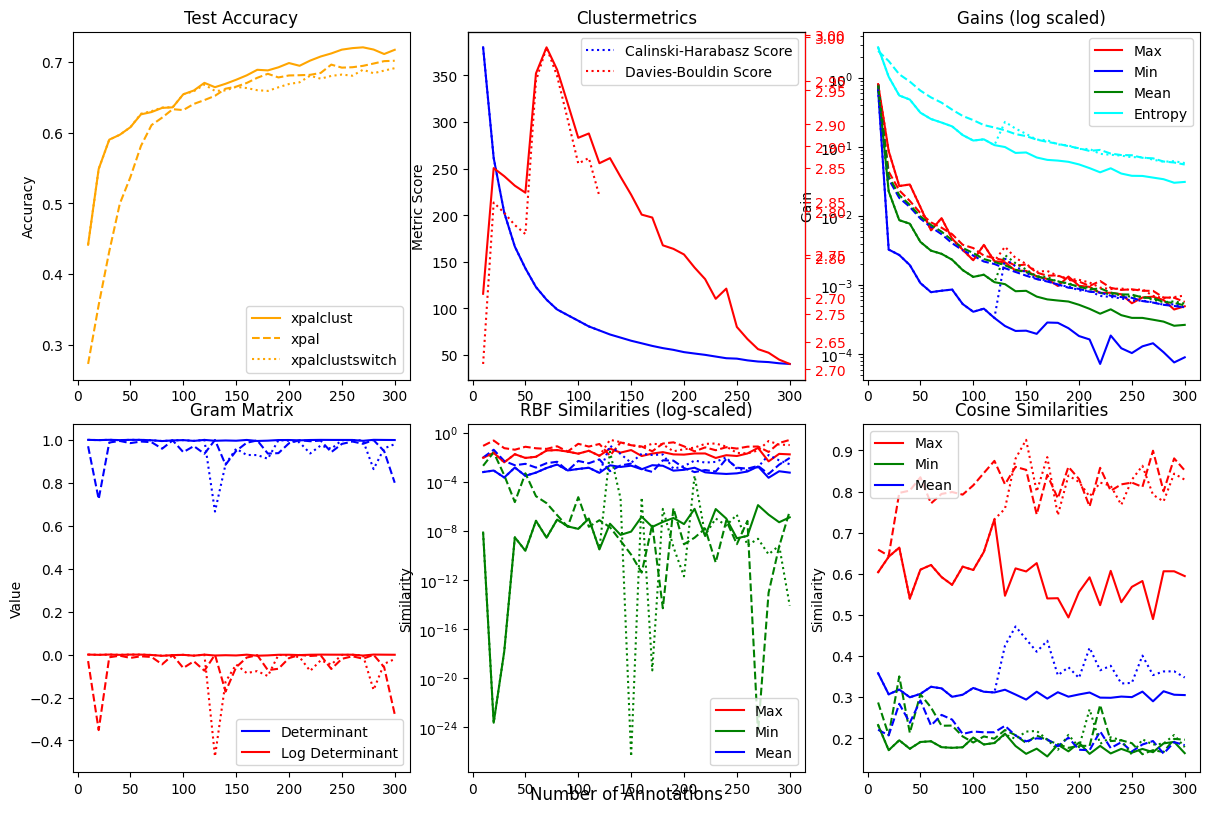

In [5]:
plot_strategy_metrics(result_list, strategy_metric_list)